# Compare the performance of the model trained on augmented data (SMOTE and T-SMOTE) and raw data : PAMAP2

2024.10.24. ~ 2024.11.02.<br>
Gyuyeon Lim (lky473736) 

<br>

- **Reference**
    - https://github.com/uchidalab/time_series_augmentation/blob/master/utils/augmentation.py
    - https://github.com/terryum/Data-Augmentation-For-Wearable-Sensor-Data/blob/master/Example_DataAugmentation_TimeseriesData.ipynb
    - https://pypi.org/project/transform3d/
    - http://dmqm.korea.ac.kr/activity/seminar/390
    - https://hyeongyuu.github.io/machine%20learning/Augmentation_timeseries/
    - https://github.com/andreasKyratzis/PAMAP2-Physical-Activity-Monitoring-Data-Analysis-and-ML/blob/master/pamap2.ipynb
    
<br>

- **addition library**
    - GPUtil
    - memory_profiler
    - transforms3d
    
<br>

### Abstract 

This study evaluates the impact of data augmentation techniques on the performance of machine learning models trained on the PAMAP2 dataset. Previously, we focused on basic augmentation methods, such as **Jitter**, **Scaling**, **Magnitude Warp**, **Time Warp**, **Random Guided Warp**, **Window Slice**, and **Window Warp**. These methods helped generate diverse patterns from the original time-series data, aiming to address class imbalance and improve model robustness.

Currently, we are extending this work by employing **T-SMOTE (Time-Series Synthetic Minority Over-sampling Technique)** and **SMOTE (Synthetic Minority Over-sampling Technique)** for data augmentation. T-SMOTE allows us to create synthetic samples that capture complex patterns in the time-series data, while SMOTE synthesizes additional samples for minority classes to address imbalance. By comparing models trained on data augmented through these advanced methods versus basic techniques, we aim to evaluate their impact on model accuracy and generalization, ultimately providing comprehensive insights into the efficacy of data augmentation for time-series classification tasks.

- **Data**
    - PAMAP2 dataset : https://archive.ics.uci.edu/dataset/231/pamap2+physical+activity+monitoring
    - data abstract : The PAMAP2 Physical Activity Monitoring dataset contains data of 18 different physical activities (such as walking, cycling, playing soccer, etc.), performed by 9 subjects wearing 3 inertial measurement units and a heart rate monitor. The dataset can be used for activity recognition and intensity estimation, while developing and applying algorithms of data processing, segmentation, feature extraction and classification.

    - window size : 100 (will use way of sliding window)

- **Model**
    - CNN-LSTM
    - U-net
    - transformer-encoder

- **Way of Augmentation**
    - **SMOTE**
    - **T-SMOTE**

### Environment and importing libraries


In [1]:
import psutil
import platform
import GPUtil

# System and CPU information
system = platform.system()
processor = platform.processor()

cpu_count = psutil.cpu_count(logical=True)
cpu_usage = psutil.cpu_percent(interval=1)
virtual_memory = psutil.virtual_memory()

print(f"System: {system}")
print(f"Processor: {processor}")
print(f"CPU Cores: {cpu_count}")
print(f"CPU Usage: {cpu_usage}%")
print(f"Total RAM: {virtual_memory.total / (1024**3):.2f} GB")
print(f"Available RAM: {virtual_memory.available / (1024**3):.2f} GB")
print(f"RAM Usage: {virtual_memory.percent}%")

# GPU information
gpus = GPUtil.getGPUs()
if gpus:
    for gpu in gpus:
        print(f"\nGPU {gpu.id}: {gpu.name}")
        print(f"  Load: {gpu.load * 100:.1f}%")
        print(f"  Free Memory: {gpu.memoryFree / 1024:.2f} GB")
        print(f"  Used Memory: {gpu.memoryUsed / 1024:.2f} GB")
        print(f"  Total Memory: {gpu.memoryTotal / 1024:.2f} GB")
        print(f"  Temperature: {gpu.temperature} °C")
else:
    print("\nNo GPU found.")


System: Linux
Processor: x86_64
CPU Cores: 16
CPU Usage: 9.1%
Total RAM: 1039.13 GB
Available RAM: 1003.37 GB
RAM Usage: 3.4%

GPU 0: CUDA GPU
  Load: nan%
  Free Memory: 38.86 GB
  Used Memory: 1.14 GB
  Total Memory: 40.00 GB
  Temperature: 34.0 °C

GPU 1: CUDA GPU
  Load: nan%
  Free Memory: 39.55 GB
  Used Memory: 0.45 GB
  Total Memory: 40.00 GB
  Temperature: 31.0 °C


In [2]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import skew
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy
from tqdm import tqdm
from scipy.interpolate import CubicSpline
from imblearn.over_sampling import SMOTE

/home/work/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/work/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.1)
  from scipy.sparse import csr_matrix, issparse
2024-11-04 07:24:39.513040: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D


In [4]:
# ignoring future warnings
import warnings
warnings.simplefilter('ignore')

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [6]:
import tensorflow as tf 
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices() )


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10060353307162522037
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 39399194624
locality {
  bus_id: 2
  numa_node: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 6107841791370247143
physical_device_desc: "device: 0, name: CUDA GPU, pci bus id: 0000:c8:00.0, compute capability: 8.0"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 40143683584
locality {
  bus_id: 2
  numa_node: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 17383647385585573065
physical_device_desc: "device: 1, name: CUDA GPU, pci bus id: 0000:cd:00.0, compute capability: 8.0"
xla_global_id: 2144165316
]


2024-11-04 07:24:42.217062: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /device:GPU:0 with 37574 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:c8:00.0, compute capability: 8.0
2024-11-04 07:24:42.219444: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /device:GPU:1 with 38284 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:cd:00.0, compute capability: 8.0


In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

-----

### data load, preprocessing


In [8]:
# column names of the data

columns = ['time_stamp', 'activity_id', 'heart_rate', 'hand_temperature', 'hand_3D_acceleration_16_x',  'hand_3D_acceleration_16_y',
         'hand_3D_acceleration_16_z', 'hand_3D_acceleration_6_x', 'hand_3D_acceleration_6_y', 'hand_3D_acceleration_6_z', 'hand_3D_gyroscope_x',
         'hand_3D_gyroscope_y',  'hand_3D_gyroscope_z', 'hand_3D_magnetometer_x', 'hand_3D_magnetometer_y', 'hand_3D_magnetometer_z',
         'hand_4D_orientation_x', 'hand_4D_orientation_y', 'hand_4D_orientation_z', 'hand_4D_orientation_w', 'chest_temperature', 'chest_3D_acceleration_16_x',
         'chest_3D_acceleration_16_y', 'chest_3D_acceleration_16_z', 'chest_3D_acceleration_6_x', 'chest_3D_acceleration_6_y',  'chest_3D_acceleration_6_z',
         'chest_3D_gyroscope_x', 'chest_3D_gyroscope_y', 'chest_3D_gyroscope_z', 'chest_3D_magnetometer_x', 'chest_3D_magnetometer_y',
         'chest_3D_magnetometer_z', 'chest_4D_orientation_x', 'chest_4D_orientation_y', 'chest_4D_orientation_z', 'chest_4D_orientation_w',
         'ankle_temperature', 'ankle_3D_acceleration_16_x', 'ankle_3D_acceleration_16_y', 'ankle_3D_acceleration_16_z', 'ankle_3D_acceleration_6_x',
         'ankle_3D_acceleration_6_y', 'ankle_3D_acceleration_6_z', 'ankle_3D_gyroscope_x', 'ankle_3D_gyroscope_y', 'ankle_3D_gyroscope_z',
         'ankle_3D_magnetometer_x', 'ankle_3D_magnetometer_y', 'ankle_3D_magnetometer_z', 'ankle_4D_orientation_x', 'ankle_4D_orientation_y',
         'ankle_4D_orientation_z', 'ankle_4D_orientation_w']

In [9]:
# data load

def load_data() :
    root = os.path.join('..', '..', '..', 'data', 'PAMAP', 'PAMAP')
    data_list = []  
    
    for i in range(101, 110) : 
        path = os.path.join(root, f"{i}.dat")
        df = pd.read_table(path, header=None, sep='\s+')
        
        print (f"{i}.dat is {df.shape}")
        
        df.columns = columns
        df['id'] = i
        
        print (f"{len(df['activity_id'].unique())}")
        
#         if (len(df['activity_id'].unique()) != 13) :
#             print ("no 13 activity in here. this won't be in completion df")
#             pass
               
#         else : 
        data_list.append(df)  

    #  data = pd.concat(data_list, ignore_index=True)
    # data.reset_index(drop=True, inplace=True)
    
    return data_list

df_list = load_data()

101.dat is (376417, 54)
13
102.dat is (447000, 54)
13
103.dat is (252833, 54)
9
104.dat is (329576, 54)
12
105.dat is (374783, 54)
13
106.dat is (361817, 54)
13
107.dat is (313599, 54)
12
108.dat is (408031, 54)
13
109.dat is (8477, 54)
2


In [10]:
# concatenation the dataframe

df = pd.concat(df_list, ignore_index=True)
df.reset_index(drop=True, inplace=True)

df

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
0,8.38,0,104.0,30.0000,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.95990,-58.143800,1.000000,0.000000,0.000000,0.000000,101
1,8.39,0,NaN,30.0000,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.89190,-58.525300,1.000000,0.000000,0.000000,0.000000,101
2,8.40,0,NaN,30.0000,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.41380,-58.399900,1.000000,0.000000,0.000000,0.000000,101
3,8.41,0,NaN,30.0000,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.76350,-58.395600,1.000000,0.000000,0.000000,0.000000,101
4,8.42,0,NaN,30.0000,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.38790,-58.269400,1.000000,0.000000,0.000000,0.000000,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872528,100.19,0,NaN,25.1875,-4.71493,10.22250,4.66893,-5.04654,9.94944,4.50736,...,-0.062676,-0.127084,-46.5153,3.58240,-0.035995,0.598531,0.033615,0.799791,-0.031075,109
2872529,100.20,0,NaN,25.1875,-4.95932,10.37130,4.12594,-4.96890,10.29620,4.43102,...,-0.027006,-0.089808,-45.7474,3.54453,0.108583,0.598428,0.033012,0.799933,-0.030018,109
2872530,100.21,0,NaN,25.1875,-4.93997,9.83615,3.70468,-5.04613,10.35690,4.14405,...,-0.038024,-0.064709,-46.3997,4.22078,0.105504,0.598233,0.033172,0.800095,-0.029416,109
2872531,100.22,0,NaN,25.1875,-4.64941,9.11129,3.51904,-5.06854,9.75268,3.87359,...,-0.025796,-0.064357,-46.5282,4.48593,0.530240,0.598116,0.033427,0.800180,-0.029208,109


In [11]:
# A function that checks the percentage of missing values,unique values,percentage of one catagory values and type against each column.

'''
    Unique_values : the component that not null
    Missing values : null
    Peercentage of Missing values : number of null / number of all samples
    Data Type : dtype of each cols
'''

def statistics(df):
    stats = []
    for col in df.columns:
        stats.append((col, df[col].nunique(), df[col].isnull().sum(), df[col].isnull().sum() * 100 / df.shape[0], df[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Missing values', 'Percentage of Missing Values', 'Data Type'])
    stats_df.set_index('Feature', drop=True, inplace=True)
    stats_df.drop(stats_df[stats_df['Missing values'] == 0].index, axis=0, inplace=True)
    stats_df.sort_values('Percentage of Missing Values', ascending=False, inplace=True)
    return stats_df

statistics(df).T

Feature,heart_rate,hand_3D_gyroscope_z,hand_temperature,hand_4D_orientation_z,hand_4D_orientation_y,hand_4D_orientation_x,hand_3D_magnetometer_z,hand_3D_magnetometer_y,hand_3D_magnetometer_x,hand_4D_orientation_w,...,chest_3D_acceleration_6_y,chest_3D_gyroscope_x,chest_4D_orientation_z,chest_3D_gyroscope_z,chest_3D_magnetometer_x,chest_3D_magnetometer_y,chest_3D_magnetometer_z,chest_4D_orientation_x,chest_4D_orientation_y,chest_3D_gyroscope_y
Unique_values,146,1875844,138,1247500,1347718,1002405,1130762,1220419,1156337,1400053,...,763044,1827061,1449428,1802080,1410128,626338,1270492,849688,951475,1918959
Missing values,2610265,13141,13141,13141,13141,13141,13141,13141,13141,13141,...,3563,3563,3563,3563,3563,3563,3563,3563,3563,3563
Percentage of Missing Values,90.8698,0.457471,0.457471,0.457471,0.457471,0.457471,0.457471,0.457471,0.457471,0.457471,...,0.124037,0.124037,0.124037,0.124037,0.124037,0.124037,0.124037,0.124037,0.124037,0.124037
Data Type,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [12]:
# Function that fills the null values with either the mean or median based on a normal test

def fillnull(columns, df=df):
    from scipy.stats import normaltest
    # Iterating Numerical columns
    for i in columns:
        # Finding Normality of feature
        st, p = normaltest(df[i].dropna())

        # Checking if normal or not
        if p > 0.05:
            # Filling with mean if normal
            df[i].fillna(df[i].mean(), inplace=True)
        else:
            # Filling with median if not normal
            df[i].fillna(df[i].median(), inplace=True)
            
# Taking out column names that have null values
num_cols = statistics(df).index

# Applying function
fillnull(num_cols)

In [13]:
# Acitvity_id = 0 is not an valid activity so it should be dropped
df.drop(df[df['activity_id']==0].index, inplace=True, axis=0)

In [14]:
# As it can be seen here there is no null values any longer in the dataframe.
print (df.isnull().sum())
print (~any(df.isnull()))

time_stamp                    0
activity_id                   0
heart_rate                    0
hand_temperature              0
hand_3D_acceleration_16_x     0
hand_3D_acceleration_16_y     0
hand_3D_acceleration_16_z     0
hand_3D_acceleration_6_x      0
hand_3D_acceleration_6_y      0
hand_3D_acceleration_6_z      0
hand_3D_gyroscope_x           0
hand_3D_gyroscope_y           0
hand_3D_gyroscope_z           0
hand_3D_magnetometer_x        0
hand_3D_magnetometer_y        0
hand_3D_magnetometer_z        0
hand_4D_orientation_x         0
hand_4D_orientation_y         0
hand_4D_orientation_z         0
hand_4D_orientation_w         0
chest_temperature             0
chest_3D_acceleration_16_x    0
chest_3D_acceleration_16_y    0
chest_3D_acceleration_16_z    0
chest_3D_acceleration_6_x     0
chest_3D_acceleration_6_y     0
chest_3D_acceleration_6_z     0
chest_3D_gyroscope_x          0
chest_3D_gyroscope_y          0
chest_3D_gyroscope_z          0
chest_3D_magnetometer_x       0
chest_3D

In [15]:
# information of dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1942872 entries, 2928 to 2872019
Data columns (total 55 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   time_stamp                  float64
 1   activity_id                 int64  
 2   heart_rate                  float64
 3   hand_temperature            float64
 4   hand_3D_acceleration_16_x   float64
 5   hand_3D_acceleration_16_y   float64
 6   hand_3D_acceleration_16_z   float64
 7   hand_3D_acceleration_6_x    float64
 8   hand_3D_acceleration_6_y    float64
 9   hand_3D_acceleration_6_z    float64
 10  hand_3D_gyroscope_x         float64
 11  hand_3D_gyroscope_y         float64
 12  hand_3D_gyroscope_z         float64
 13  hand_3D_magnetometer_x      float64
 14  hand_3D_magnetometer_y      float64
 15  hand_3D_magnetometer_z      float64
 16  hand_4D_orientation_x       float64
 17  hand_4D_orientation_y       float64
 18  hand_4D_orientation_z       float64
 19  hand_4D_orientation_w  

In [16]:
# delete cols that doesn't need

df = df.drop (['time_stamp', 'id'], axis=1)
df.columns

Index(['activity_id', 'heart_rate', 'hand_temperature',
       'hand_3D_acceleration_16_x', 'hand_3D_acceleration_16_y',
       'hand_3D_acceleration_16_z', 'hand_3D_acceleration_6_x',
       'hand_3D_acceleration_6_y', 'hand_3D_acceleration_6_z',
       'hand_3D_gyroscope_x', 'hand_3D_gyroscope_y', 'hand_3D_gyroscope_z',
       'hand_3D_magnetometer_x', 'hand_3D_magnetometer_y',
       'hand_3D_magnetometer_z', 'hand_4D_orientation_x',
       'hand_4D_orientation_y', 'hand_4D_orientation_z',
       'hand_4D_orientation_w', 'chest_temperature',
       'chest_3D_acceleration_16_x', 'chest_3D_acceleration_16_y',
       'chest_3D_acceleration_16_z', 'chest_3D_acceleration_6_x',
       'chest_3D_acceleration_6_y', 'chest_3D_acceleration_6_z',
       'chest_3D_gyroscope_x', 'chest_3D_gyroscope_y', 'chest_3D_gyroscope_z',
       'chest_3D_magnetometer_x', 'chest_3D_magnetometer_y',
       'chest_3D_magnetometer_z', 'chest_4D_orientation_x',
       'chest_4D_orientation_y', 'chest_4D_orientat

In [17]:
import pandas as pd

def correlation_matrix(df):
    corr = df.corr()

    sorted_corr = corr['activity_id'].abs().sort_values(ascending=False)

    return sorted_corr

sorted_correlations = correlation_matrix(df)

print(sorted_correlations)

activity_id                   1.000000
chest_3D_acceleration_6_z     0.429279
chest_3D_acceleration_16_z    0.428210
ankle_4D_orientation_w        0.337902
chest_4D_orientation_x        0.324685
chest_3D_magnetometer_y       0.298333
chest_3D_magnetometer_z       0.265201
chest_3D_magnetometer_x       0.241262
ankle_3D_magnetometer_z       0.209349
hand_4D_orientation_x         0.207247
ankle_3D_magnetometer_x       0.199028
ankle_temperature             0.196692
hand_3D_magnetometer_y        0.188350
ankle_4D_orientation_y        0.187077
chest_temperature             0.160191
hand_temperature              0.159274
chest_3D_acceleration_16_x    0.149992
chest_3D_acceleration_6_x     0.147551
ankle_3D_acceleration_6_x     0.145586
ankle_3D_acceleration_16_x    0.134114
hand_3D_acceleration_16_x     0.131847
hand_3D_acceleration_6_x      0.131142
hand_3D_acceleration_6_z      0.118543
hand_3D_acceleration_16_z     0.116912
chest_3D_acceleration_16_y    0.105699
hand_4D_orientation_z    

In [18]:
'''
    To reduce the complexity of the model due to too many features, 
    only features related to 'ankle', 'chest', 'heart rate' will be retained.
    because of memory fraction
'''

col_activity_id = df['activity_id']
col_heart_rate = df['heart_rate']

df = df.filter(regex='(ankle|chest)', axis=1) # using regex (ankle or chest)

df['heart_rate'] = col_heart_rate
df['activity_id'] = col_activity_id

In [19]:
# see that target is 0-based

print (df['activity_id'].unique())


'''
    we need to encoding now to 0-based
    (labelencoding)
'''

[ 1  2  3 17 16 12 13  4  7  6  5 24]


'\n    we need to encoding now to 0-based\n    (labelencoding)\n'

In [20]:
# label encoding

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['activity_id'] = encoder.fit_transform(df['activity_id'])

print (df['activity_id'].unique())

[ 0  1  2 10  9  7  8  3  6  5  4 11]


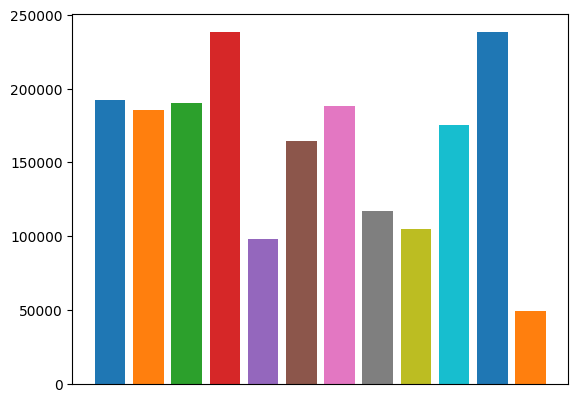

activity_id
3     238761
10    238690
0     192523
2     189931
6     188107
1     185188
9     175353
5     164600
7     117216
8     104944
4      98199
11     49360
Name: count, dtype: int64


"\n    This situation solved using SMOTE and oversampling random position at records before bunches of documents.\n    But this data is time-series, has depandancy of time.\n    \n    so i will do the original augmentation that Terry Taewoong Um offered. \n    That file will be uploaded at './augmentation'\n"

In [21]:
# activity_id - countplot, value_count

import math

target = np.unique(df['activity_id'])

width = 1
for compo in target : 
    plt.bar(width, len(df[df['activity_id'] == compo]), 
            label=compo)
    width += 1
    
plt.xticks([], [])
plt.show()

print (df['activity_id'].value_counts())

'''
    This situation solved using SMOTE and oversampling random position at records before bunches of documents.
    But this data is time-series, has depandancy of time.
    
    so i will do the original augmentation that Terry Taewoong Um offered. 
    That file will be uploaded at './augmentation'
'''

In [22]:
# Z-score normalization

from sklearn.preprocessing import StandardScaler

X = df[[feature_name for feature_name in df.columns if feature_name != 'activity_id']]
y = df['activity_id']

SS = StandardScaler()
X = SS.fit_transform(X)

df = pd.DataFrame(data=X, 
                        columns = [feature_name for feature_name in df.columns if feature_name != 'activity_id'])
df['activity_id'] = y.values

df

,chest_temperature,chest_3D_acceleration_16_x,chest_3D_acceleration_16_y,chest_3D_acceleration_16_z,chest_3D_acceleration_6_x,chest_3D_acceleration_6_y,chest_3D_acceleration_6_z,chest_3D_gyroscope_x,chest_3D_gyroscope_y,chest_3D_gyroscope_z,...,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,heart_rate,activity_id
0,-2.671552,-0.119921,0.306155,-0.042085,-0.031848,0.321978,-0.073665,0.069143,0.008567,-0.094160,...,-0.002954,-1.612155,-1.768779,-3.842566,2.042947,0.015937,-0.910038,0.118979,0.005952,0
1,-2.671552,-0.076152,0.306108,-0.041795,-0.040394,0.328214,-0.073627,0.030607,-0.063867,-0.116397,...,-0.000834,-1.600335,-1.743646,-3.842363,2.042947,0.015937,-0.910038,0.118979,0.005952,0
2,-2.671552,-0.036209,0.321155,-0.090380,-0.031419,0.334419,-0.060953,-0.015592,0.047400,-0.074207,...,-0.006259,-1.570259,-1.718901,-3.854879,2.042947,0.015937,-0.910038,0.118979,0.005952,0
3,-2.671552,-0.055467,0.321393,-0.057974,-0.014315,0.331303,-0.070507,0.026012,-0.106841,-0.164027,...,0.009598,-1.593402,-1.779832,-3.817681,2.042947,0.015937,-0.910038,0.118979,0.005952,0
4,-2.671552,0.010843,0.321372,-0.049403,-0.014795,0.318868,-0.086386,-0.011805,-0.044453,-0.051662,...,-0.006979,-1.562796,-1.780742,-3.817925,2.042947,0.015937,-0.910038,0.118979,-0.975223,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942867,-2.546063,-0.412642,0.259591,-0.141467,-0.441591,0.275760,-0.196486,-0.340703,-0.264536,0.282075,...,-0.000899,-0.775617,-0.103795,-0.885062,0.468808,-0.495552,1.215173,-0.671289,0.005952,11
1942868,-2.546063,-0.348588,0.220875,-0.157180,-0.459996,0.225957,-0.209268,-0.204353,-0.282429,0.223975,...,-0.005936,-0.789134,-0.103127,-0.849070,0.468646,-0.495696,1.215502,-0.670876,0.005952,11
1942869,-2.546063,-0.326475,0.251680,-0.157136,-0.381987,0.216529,-0.193624,-0.062557,-0.224092,0.335552,...,-0.004977,-0.760794,-0.122171,-0.848952,0.467805,-0.496194,1.216303,-0.670112,0.005952,11
1942870,-2.546063,-0.263392,0.259102,-0.189275,-0.346874,0.232057,-0.180979,-0.051073,-0.227636,0.384813,...,-0.007352,-0.782375,-0.091495,-0.841855,0.467511,-0.496153,1.217100,-0.669379,6.628887,11


In [23]:
# input, target split

input_PAMAP = df.drop('activity_id', axis=1)
target_PAMAP = df['activity_id']

input_PAMAP.shape, target_PAMAP.shape

((1942872, 35), (1942872,))

------

### sliding window : split_sequences_freq()

<img src="https://velog.velcdn.com/images/wlwl99/post/e0ebddc2-e075-41e5-bec6-ac424364d1da/image.png" width=400px>

The function above is designed using the **sliding window technique**, but this time the target is determined by **frequency** rather than the last value. Sliding window is a common approach used in two-pointer algorithms, where elements are selected by sliding across the dataset, as illustrated in the earlier figure.

In this function, **`len(sequences)` represents the number of records (rows) in the DataFrame**. The loop iterates through each row, with `i` representing the current row index. `end_ix` is calculated by adding `n_steps` to the current row index, where `n_steps` is the size of the window. Here, the **window slides over the data, selecting a block of rows**.

The loop terminates if `end_ix` exceeds the total number of rows in the DataFrame. Inside the loop, `seq_x` is the input data that selects the rows between the `i`-th and `end_ix - 1`-th row, excluding the last column (target column). `seq_y` is the corresponding target data, which includes the values in the last column for those rows.

Instead of using the last target value as in the previous approach, **the most frequent target class within the window** is selected as the target. This is done using the `Counter` from the `collections` module, which finds the most common class in `seq_y`. Finally, the input data (`X`) and the most frequent class (`y`) are stored for each window.

In [24]:
import pandas as pd
import numpy as np

def split_sequences_freq(sequences, n_steps, hop=1):
    X, y = list(), list()
    
    # Check if sequences is a DataFrame, convert if necessary
    if not isinstance(sequences, pd.DataFrame):
        sequences = pd.DataFrame(sequences)

    # Class labels (last column)
    class_labels = sequences.iloc[:, -1].values
    
    # Remove rows with NaN values in the last column
    if np.any(pd.isna(class_labels)):
        # Option 1: Drop rows with NaN in the class labels
        sequences = sequences.dropna(subset=[sequences.columns[-1]])
        class_labels = sequences.iloc[:, -1].values

    for i in range(0, len(sequences) - n_steps + 1, hop):
        seq_x = sequences.iloc[i:i + n_steps, :-1].values
        seq_y = class_labels[i:i + n_steps]  # Extracting only the target values

        # Using np.unique to find the most frequent class
        values, counts = np.unique(seq_y, return_counts=True)
        
        # Check for empty values
        if len(values) == 0 or np.isnan(values).all():
            continue  # Skip if no valid class is found

        most_frequent_class = values[np.argmax(counts)]  # Get the class with max count
        
        # Skip if most frequent class is NaN
        if np.isnan(most_frequent_class):
            continue

        X.append(seq_x)
        y.append(int(most_frequent_class))

    return np.array(X), np.array(y)


------

### Modeling

In [25]:
# CNN-LSTM

from tensorflow import keras
from tensorflow.keras import layers, regularizers

def build_CNN_LSTM(input_shape, target_size, l2_lambda=0.01):
    model = keras.Sequential()

    # Convolutional layers
    model.add(layers.Conv1D(128, kernel_size=4, padding='same', strides=1, activation='relu', 
                            kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(64, kernel_size=3, padding='same', strides=1, activation='relu', 
                            kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dropout(0.4))

    # LSTM layers
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(32, return_sequences=False))
    model.add(layers.Dropout(0.5))

    # Fully connected layers
    model.add(layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(80, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(60, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))

    # Output layer
    model.add(layers.Dense(target_size, activation='softmax'))

    return model


In [26]:
from tensorflow.keras import layers, models, regularizers

def build_unet_1d_custom(input_shape, num_classes, l2_lambda=0.01):

    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(inputs)
    c1 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(c1)
    p1 = layers.MaxPooling1D(pool_size=2)(c1)  # Downsampling

    c2 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(p1)
    c2 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(c2)
    p2 = layers.MaxPooling1D(pool_size=2)(c2)  # Downsampling

    c3 = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(p2)
    c3 = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(c3)
    p3 = layers.MaxPooling1D(pool_size=2)(c3)  # Downsampling

    # Bottleneck
    b1 = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(p3)
    b1 = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(b1)

    # Decoder
    u3 = layers.Conv1DTranspose(16, kernel_size=2, strides=2, padding='same')(b1)  # Upsampling
    c3_shape = layers.Lambda(lambda x: x[:, :u3.shape[1], :])(c3)  # Adjust shape of c3 to match u3
    u3 = layers.concatenate([u3, c3_shape], axis=-1)  # Concatenate

    c4 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(u3)
    c4 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(c4)

    u4 = layers.Conv1DTranspose(32, kernel_size=2, strides=2, padding='same')(c4)  # Upsampling
    c2_shape = layers.Lambda(lambda x: x[:, :u4.shape[1], :])(c2)  # Adjust shape of c2 to match u4
    u4 = layers.concatenate([u4, c2_shape], axis=-1)  # Concatenate

    c5 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(u4)
    c5 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(c5)

    # Output layer
    f1 = layers.Flatten()(c5)
    dense1 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda))(f1)
    outputs = layers.Dense(num_classes, activation='softmax')(dense1)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model


In [27]:
# transformer-encoder

from tensorflow.keras import regularizers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2, l2_lambda=0.02):
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu",
                           kernel_regularizer=regularizers.l2(l2_lambda))(res)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1,
                           kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_transformer(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.2,
    mlp_dropout=0.3,
    n_classes=0,
    l2_lambda=0.02
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout, l2_lambda)

    x = keras.layers.GlobalMaxPooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = keras.layers.Dense(dim, activation="relu",
                              kernel_regularizer=regularizers.l2(l2_lambda))(x)
        x = keras.layers.Dropout(mlp_dropout)(x)
    outputs = keras.layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [28]:
# build pipeline to fit

import time
from memory_profiler import profile
from keras.callbacks import Callback

class EpochTimeLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()  

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time  
        print(f"epoch {epoch + 1} completed : {elapsed_time:.2f} seconds", end='\n')

@profile  # to protect memory overflow
def run_all_model(X, y, models, epochs=50):
    histories = {
        'CNN_LSTM' : None,
        'UNet' : None,
        'transformer_encoder' : None
    }
    
    trained_models = {
        'CNN_LSTM' : None,
        'UNet' : None,
        'transformer_encoder' : None
    }
    
#     early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

    for idx, model in enumerate(models) : 
        print (f"model {idx} running")    
        try:
            start_time = time.time()
            history = model.fit(X, y, epochs=epochs, 
                                validation_split=0.2,
                                batch_size=512,
                                callbacks=[EpochTimeLogger()], 
                                verbose=0)
            
            end_time = time.time()
            total_time = end_time - start_time
            avg_time_per_epoch = total_time / epochs
            
            print(f"Total training time: {total_time / 60:.2f} minutes")
            print(f"Average time per epoch: {avg_time_per_epoch:.2f} seconds")
            
            if idx == 0: 
                histories['CNN_LSTM'] = history
                print ("CNN_LSTM completed")
                trained_models['CNN_LSTM'] = model
            elif idx == 1: 
                histories['UNet'] = history
                print ("UNet completed")
                trained_models['UNet'] = model
            else: 
                histories['transformer_encoder'] = history
                print ("transformer_encoder completed")
                trained_models['transformer_encoder'] = model
                
        except Exception as e: 
            print (f"Error occurred while running model {idx}: {e}")
            
        print ()
    
    return histories, trained_models

def activate_all_model(X, y, input_shape, n_classes, epochs=50):
    CNN_LSTM = build_CNN_LSTM(input_shape=input_shape,
                             target_size=n_classes)
    UNet = build_unet_1d_custom(input_shape=input_shape,
                               num_classes=n_classes)
    transformer_encoder = build_transformer(
                                input_shape=input_shape,
                                head_size=64,
                                num_heads=4,
                                ff_dim=4,
                                num_transformer_blocks=3,
                                mlp_units=[32],
                                mlp_dropout=0.1,
                                dropout=0.2,
                                n_classes=n_classes
                            )
    
    CNN_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'], 
                     loss='sparse_categorical_crossentropy')
    UNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'], 
                 loss='sparse_categorical_crossentropy')
    transformer_encoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'], 
                                loss='sparse_categorical_crossentropy')
    
    models = [CNN_LSTM, UNet, transformer_encoder]
    
    CNN_LSTM.build(input_shape=(None, *input_shape))
    UNet.build(input_shape=(None, *input_shape))
    transformer_encoder.build(input_shape=(None, *input_shape))
    
    print(f"CNN_LSTM model parameters: {CNN_LSTM.count_params()}")
    print(f"UNet model parameters: {UNet.count_params()}")
    print(f"Transformer Encoder model parameters: {transformer_encoder.count_params()}")

    histories, trained_models = run_all_model(X, y, models, epochs)
    return histories, trained_models

------

### original dataframe (no augmentation)

In [29]:
# no augmentation. train set, test set split

print (df.shape)

idx = int(df.shape[0]*0.8)

X_train = df.iloc[:idx][[feature_name for feature_name in df.columns if feature_name != 'activity_id']]
y_train = df.iloc[:idx]['activity_id']
X_test = df.iloc[idx:][[feature_name for feature_name in df.columns if feature_name != 'activity_id']]
y_test = df.iloc[idx:]['activity_id']

X_train.shape, X_test.shape

(1942872, 36)


((1554297, 35), (388575, 35))

In [30]:
# no augmentation. so just use split_sequence_freq

'''
    the data information indicates that the sampled data has a frequency of 100Hz
    so the window size should be configured to be the same as the frequency
'''

train_set = np.c_[X_train, y_train]
test_set = np.c_[X_test, y_test]

X_train_seq, y_train_seq = split_sequences_freq(train_set, 100, 20) # tie 100 records, hop 20
print ("train : ", X_train_seq.shape, y_train_seq.shape)

X_test_seq, y_test_seq = split_sequences_freq(test_set, 100, 20) # tie 100 records, hop 20
print ("test : ", X_test_seq.shape, y_test_seq.shape)

print (len(set(y_train_seq)))
print (len(set(y_test_seq)))

train :  (77710, 100, 35) (77710,)
test :  (19424, 100, 35) (19424,)
12
12


In [31]:
# compile -> fit -> return histories

input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
n_classes = 12
histories_original, trained_models = activate_all_model(X_train_seq, y_train_seq, input_shape, n_classes)

2024-11-04 07:25:44.443399: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37574 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:c8:00.0, compute capability: 8.0
2024-11-04 07:25:44.445434: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38284 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:cd:00.0, compute capability: 8.0
2024-11-04 07:25:45.618552: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-04 07:25:45.619663: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Exec

CNN_LSTM model parameters: 107228
UNet model parameters: 164572
Transformer Encoder model parameters: 114934
ERROR: Could not find file /tmp/ipykernel_36490/2750405356.py
model 0 running


2024-11-04 07:25:49.569763: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-04 07:25:49.576144: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-04 07:25:49.581449: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

epoch 1 completed : 23.11 seconds
epoch 2 completed : 2.16 seconds
epoch 3 completed : 2.09 seconds
epoch 4 completed : 2.12 seconds
epoch 5 completed : 2.12 seconds
epoch 6 completed : 2.15 seconds
epoch 7 completed : 2.08 seconds
epoch 8 completed : 2.07 seconds
epoch 9 completed : 2.06 seconds
epoch 10 completed : 2.09 seconds
epoch 11 completed : 2.14 seconds
epoch 12 completed : 2.14 seconds
epoch 13 completed : 2.10 seconds
epoch 14 completed : 2.07 seconds
epoch 15 completed : 2.11 seconds
epoch 16 completed : 2.07 seconds
epoch 17 completed : 2.10 seconds
epoch 18 completed : 2.06 seconds
epoch 19 completed : 2.09 seconds
epoch 20 completed : 2.07 seconds
epoch 21 completed : 2.12 seconds
epoch 22 completed : 2.06 seconds
epoch 23 completed : 2.06 seconds
epoch 24 completed : 2.07 seconds
epoch 25 completed : 2.09 seconds
epoch 26 completed : 2.07 seconds
epoch 27 completed : 2.08 seconds
epoch 28 completed : 2.12 seconds
epoch 29 completed : 2.11 seconds
epoch 30 completed : 2

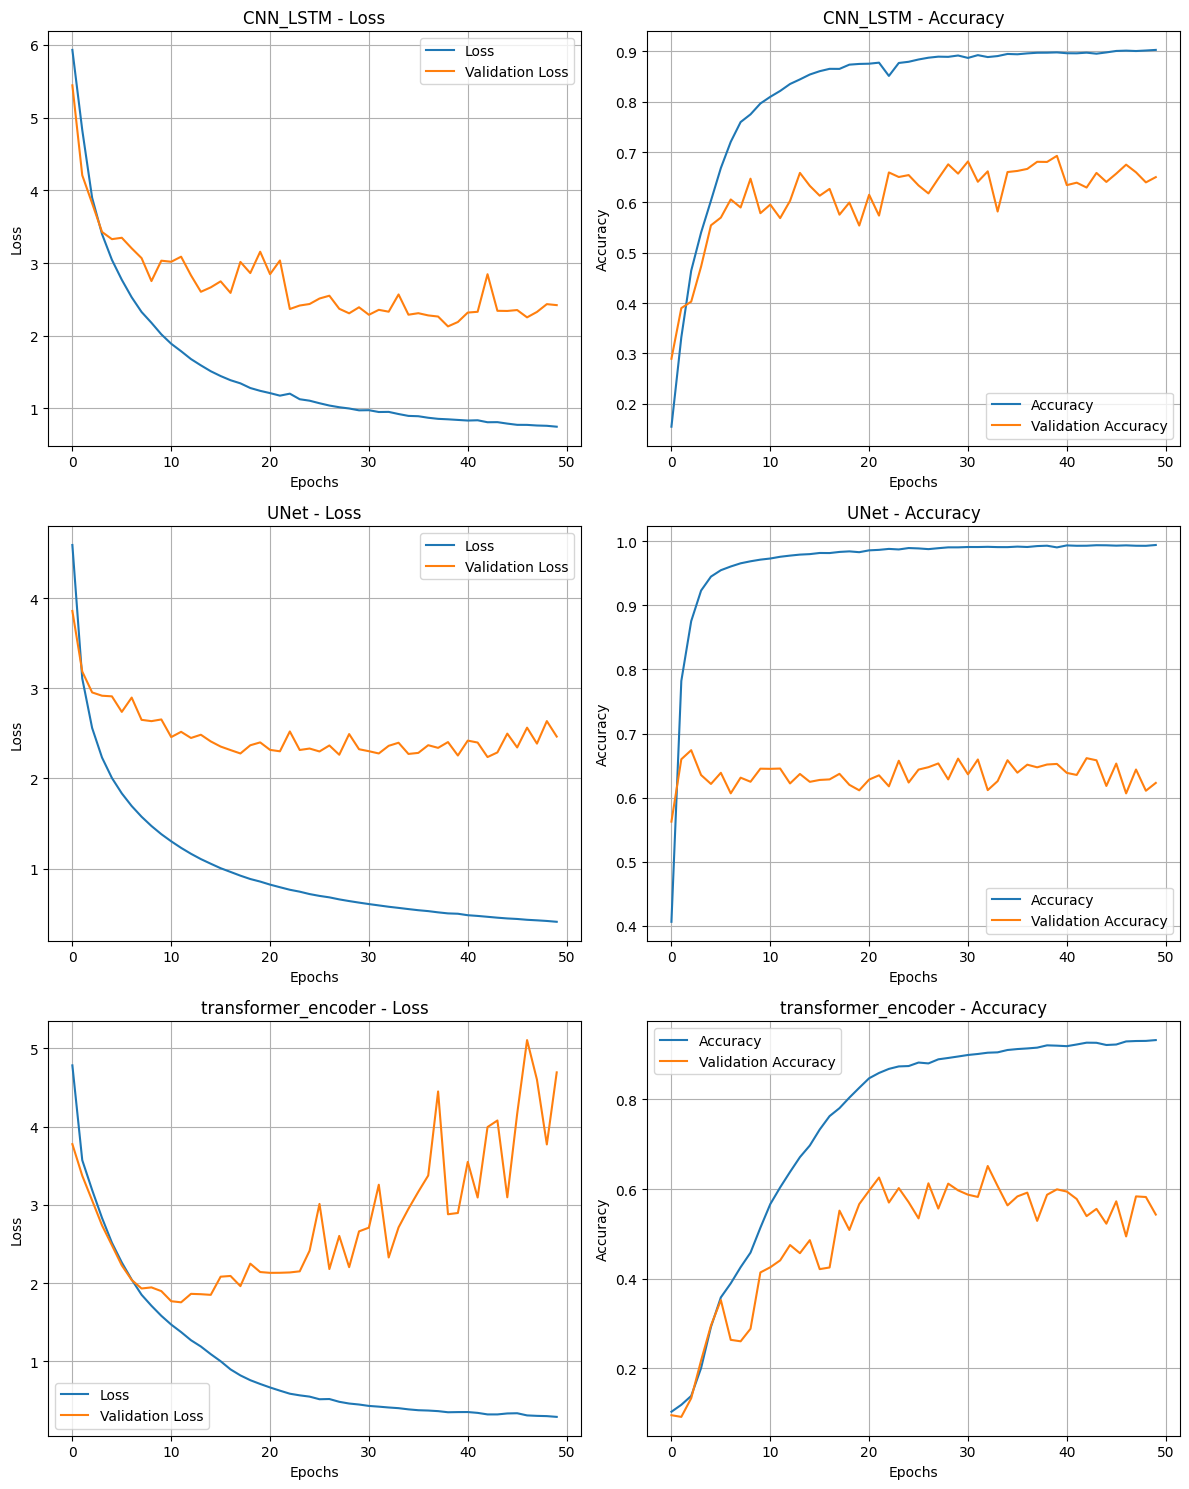

In [32]:
# loss, validation loss, acc, validation acc visualliztion

def draw_history(histories):
    num_models = len(histories)
    fig, ax = plt.subplots(num_models, 2, figsize=(12, 5 * num_models))

    for i, (model_name, history) in enumerate(histories.items()):
        ax[i, 0].plot(history.history['loss'], label='Loss')
        ax[i, 0].plot(history.history['val_loss'], label='Validation Loss')
        ax[i, 0].set_title(f'{model_name} - Loss')
        ax[i, 0].set_xlabel('Epochs')
        ax[i, 0].set_ylabel('Loss')
        ax[i, 0].legend()
        ax[i, 0].grid()

        ax[i, 1].plot(history.history['accuracy'], label='Accuracy')
        ax[i, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax[i, 1].set_title(f'{model_name} - Accuracy')
        ax[i, 1].set_xlabel('Epochs')
        ax[i, 1].set_ylabel('Accuracy')
        ax[i, 1].legend()
        ax[i, 1].grid()

    plt.tight_layout()
    plt.show()

draw_history(histories_original)

In [33]:
# evaulate

def extract_train_test_scores(models, X_train, y_train, X_test, y_test) :
    scores = {}
    for model_name, model in models.items():
        if model:
            train_score = model.evaluate(X_train, y_train, verbose=0)
            test_score  = model.evaluate(X_test, y_test, verbose=0)
            scores[model_name] = {'train_score': train_score, 'test_score': test_score}
    return scores


evaluation_original = extract_train_test_scores(trained_models, X_train_seq, y_train_seq,
                                                X_test_seq, y_test_seq)
print (evaluation_original)

{'CNN_LSTM': {'train_score': [1.0161712169647217, 0.8730794191360474], 'test_score': [2.9072890281677246, 0.5641474723815918]}, 'UNet': {'train_score': [0.8171679377555847, 0.9208338856697083], 'test_score': [3.4650936126708984, 0.5741865634918213]}, 'transformer_encoder': {'train_score': [2.054184913635254, 0.7158280611038208], 'test_score': [4.1817626953125, 0.40362438559532166]}}


In [34]:
# get accuracy, precision, recall, F1 score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def extract_performance_metrics(models, X_test, y_test) :
    metrics = {}
    for model_name, model in models.items():
        if model:
            y_pred = model.predict(X_test)
            y_pred_classes = y_pred.argmax(axis=1)
            accuracy  = accuracy_score(y_test, y_pred_classes)
            precision = precision_score(y_test, y_pred_classes, average='weighted')
            recall    = recall_score(y_test, y_pred_classes, average='weighted')
            f1        = f1_score(y_test, y_pred_classes, average='weighted')
            metrics[model_name] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1}
    return metrics

performances_original = extract_performance_metrics(trained_models, X_test_seq, y_test_seq)
print (performances_original)

2024-11-04 07:34:33.177960: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-04 07:34:33.179518: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-04 07:34:33.180531: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

607/607 [==============================] - 2s 2ms/step
{'CNN_LSTM': {'accuracy': 0.5641474464579901, 'precision': 0.5571550810734086, 'recall': 0.5641474464579901, 'f1_score': 0.5298796267544356}, 'UNet': {'accuracy': 0.5741865733113674, 'precision': 0.5643275226233095, 'recall': 0.5741865733113674, 'f1_score': 0.5478997474841114}, 'transformer_encoder': {'accuracy': 0.40362438220757824, 'precision': 0.47002256587016106, 'recall': 0.40362438220757824, 'f1_score': 0.39431417320224965}}


607/607 [==============================] - 2s 4ms/step
Classification Report for CNN_LSTM:

              precision    recall  f1-score   support

           0       0.24      0.01      0.02      1208
           1       0.77      0.92      0.84      1147
           2       0.32      0.47      0.38      1258
           3       0.72      0.67      0.70      3263
           4       0.48      0.80      0.60      1012
           5       0.80      0.90      0.85      2408
           6       0.67      0.58      0.62      2880
           7       0.54      0.72      0.62      1466
           8       0.15      0.34      0.21      1063
           9       0.57      0.71      0.63      1313
          10       0.53      0.05      0.10      1649
          11       0.00      0.00      0.00       757

    accuracy                           0.56     19424
   macro avg       0.48      0.52      0.46     19424
weighted avg       0.56      0.56      0.53     19424



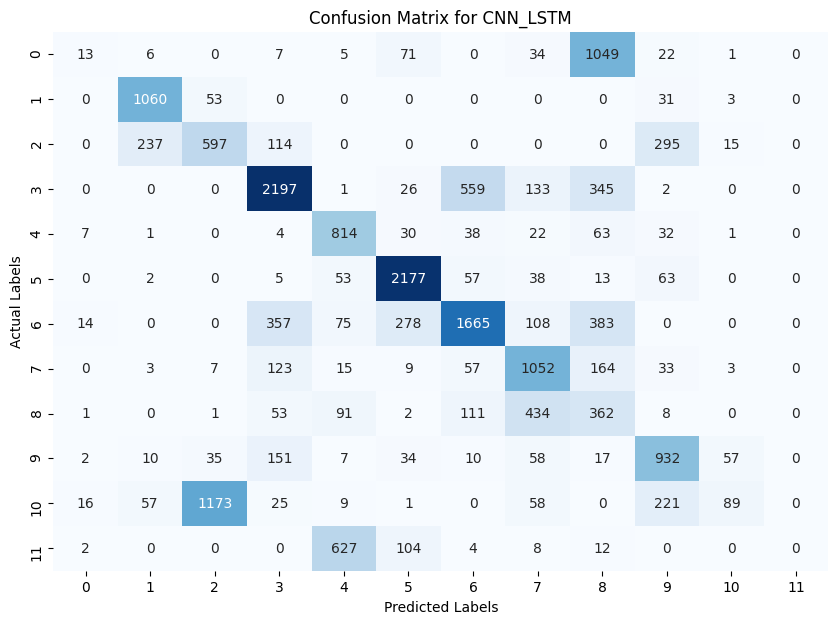

607/607 [==============================] - 1s 2ms/step
Classification Report for UNet:

              precision    recall  f1-score   support

           0       0.50      0.94      0.65      1208
           1       0.05      0.01      0.01      1147
           2       0.26      0.45      0.33      1258
           3       0.71      0.68      0.70      3263
           4       0.53      0.87      0.66      1012
           5       0.95      0.87      0.90      2408
           6       0.79      0.48      0.59      2880
           7       0.70      0.45      0.55      1466
           8       0.35      0.71      0.47      1063
           9       0.49      0.69      0.57      1313
          10       0.00      0.00      0.00      1649
          11       0.71      0.73      0.72       757

    accuracy                           0.57     19424
   macro avg       0.50      0.57      0.51     19424
weighted avg       0.56      0.57      0.55     19424



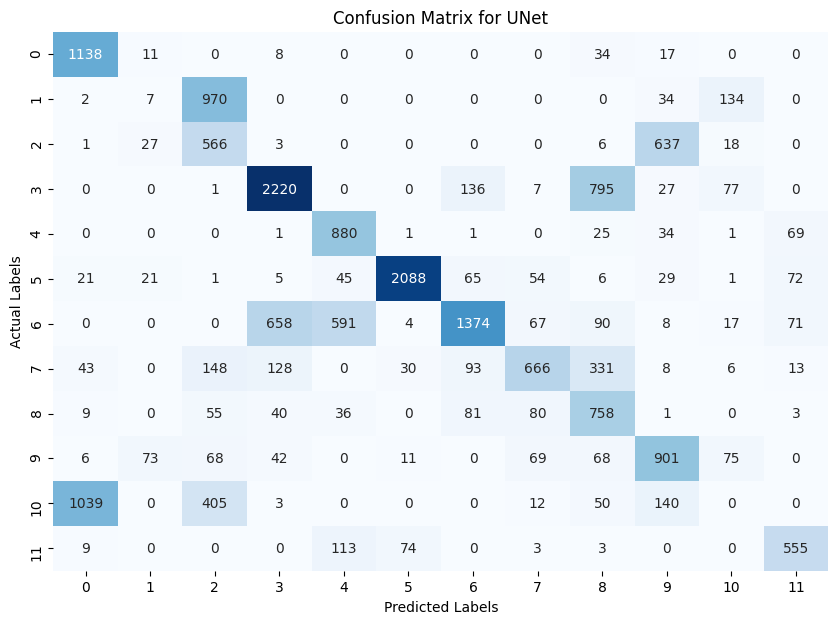

607/607 [==============================] - 1s 2ms/step
Classification Report for transformer_encoder:

              precision    recall  f1-score   support

           0       0.02      0.01      0.02      1208
           1       0.31      0.60      0.40      1147
           2       0.73      0.52      0.61      1258
           3       0.63      0.40      0.49      3263
           4       0.30      0.08      0.13      1012
           5       0.79      0.84      0.82      2408
           6       0.77      0.25      0.38      2880
           7       0.31      0.40      0.35      1466
           8       0.15      0.48      0.23      1063
           9       0.25      0.53      0.34      1313
          10       0.07      0.01      0.02      1649
          11       0.42      0.70      0.52       757

    accuracy                           0.40     19424
   macro avg       0.39      0.40      0.36     19424
weighted avg       0.47      0.40      0.39     19424



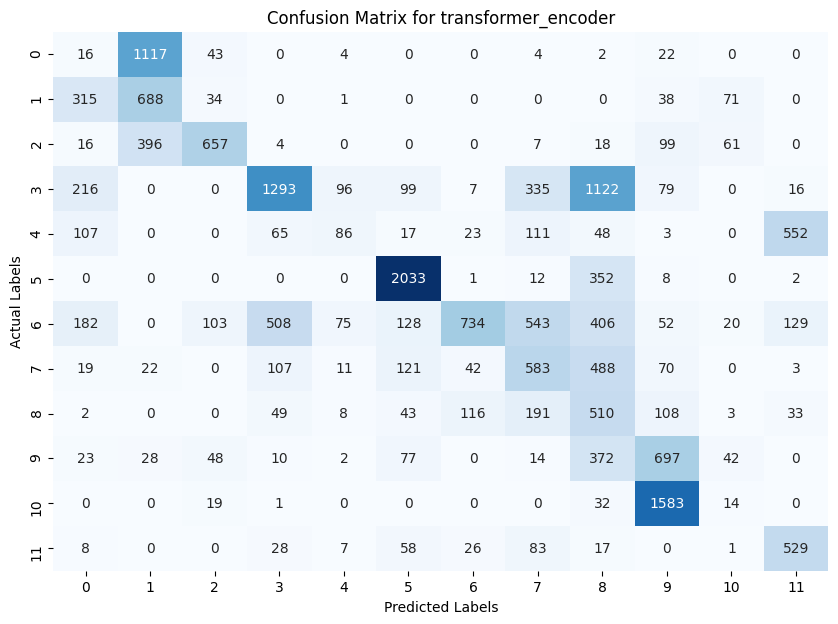

In [35]:
# draw confusion matrix, print the report

from sklearn.metrics import classification_report, confusion_matrix

def plot_classification_report_confusion_matrix(models, X_test, y_test):
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        print(f"Classification Report for {model_name}:\n")
        print(classification_report(y_test, y_pred_classes))

        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred_classes)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f'Confusion Matrix for {model_name}')
        plt.ylabel('Actual Labels')
        plt.xlabel('Predicted Labels')
        plt.show()


            
plot_classification_report_confusion_matrix(trained_models, X_test_seq, y_test_seq)

----

### SMOTE



In [36]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd

def apply_smote_to_dfs(df_list):
    smote_results = []
    
    # Determine common features upfront based on all DataFrames
    all_columns = set.intersection(*[set(df.columns) for df in df_list if 'activity_id' in df.columns])
    common_features = [col for col in all_columns if 'ankle' in col or 'chest' in col]
    common_features.append('heart_rate')

    for i, df_compo in enumerate(df_list):
        # Assume 'statistics' and 'fillnull' are defined elsewhere
        num_cols = statistics(df_compo).index
        fillnull(num_cols, df_compo)
        
        print(f"{i} started")
        print("fillnull done")

        # Drop rows where activity_id is 0
        df_compo.drop(df_compo[df_compo['activity_id'] == 0].index, inplace=True)

        # Drop unnecessary columns
        columns_to_drop = ['time_stamp', 'id']
        df_compo = df_compo.drop(columns=[col for col in columns_to_drop if col in df_compo.columns])
        
        print("drop some attribute done")

        # Encode the target variable
        encoder = LabelEncoder()
        df_compo['activity_id'] = encoder.fit_transform(df_compo['activity_id'])
        y = df_compo['activity_id']

        # Prepare feature matrix
        X = df_compo[[feature_name for feature_name in df_compo.columns if feature_name != 'activity_id']]
        SS = StandardScaler()
        X = SS.fit_transform(X)

        # Create a DataFrame for the scaled features
        df_compo = pd.DataFrame(data=X, columns=[feature_name for feature_name in df_compo.columns if feature_name != 'activity_id'])
        df_compo['activity_id'] = y.values
        
        print("LE, SS done")

        # Apply SMOTE
        try: 
            df_filtered = df_compo[common_features]
            print("filter done")
            
            smote = SMOTE(sampling_strategy='auto', n_jobs=-1)
            X_resampled, y_resampled = smote.fit_resample(df_filtered, y)
            print("SMOTE done")

            df_resampled = pd.DataFrame(X_resampled, columns=common_features)
            df_resampled['activity_id'] = y_resampled

            smote_results.append(df_resampled)
            
            print(df_resampled.info())
            print(df_resampled.shape)
            
            print (df_resampled['activity_id'].value_counts())
            
        except Exception as e:
            print(f"SMOTE failed: {e}")
            smote_results.append(df_filtered.assign(activity_id=y))
            print(df_filtered.info())
            print(df_filtered.shape)
           #  print (df_filtered['activity_id'].value_counts())
    
    return smote_results

df_list_SMOTE = apply_smote_to_dfs(df_list)

0 started
fillnull done
drop some attribute done
LE, SS done
filter done
SMOTE done
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326244 entries, 0 to 326243
Data columns (total 36 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ankle_3D_gyroscope_y        326244 non-null  float64
 1   chest_3D_magnetometer_x     326244 non-null  float64
 2   ankle_4D_orientation_y      326244 non-null  float64
 3   chest_4D_orientation_x      326244 non-null  float64
 4   ankle_3D_acceleration_16_x  326244 non-null  float64
 5   chest_3D_acceleration_16_y  326244 non-null  float64
 6   ankle_3D_magnetometer_x     326244 non-null  float64
 7   ankle_3D_acceleration_6_x   326244 non-null  float64
 8   ankle_3D_acceleration_6_z   326244 non-null  float64
 9   ankle_4D_orientation_z      326244 non-null  float64
 10  chest_3D_acceleration_16_z  326244 non-null  float64
 11  ankle_3D_magnetometer_z     326244 non-null  f

In [37]:
activity_temp = df_list[-1]['activity_id'] 
# df_list_SMOTE[-1] = df_list_SMOTE[-1].drop('activity_id', axis=1)
df_list_SMOTE[-1]['activity_id'] = activity_temp

for compo in df_list_SMOTE : 
    print (compo.shape) 

(326244, 36)
(390396, 36)
(232288, 36)
(231421, 36)
(396408, 36)
(452928, 36)
(370920, 36)
(395880, 36)
(6391, 36)


In [38]:
# X_list = [X_train_seq]
# y_list = [y_train_seq]

# for i in range (len(df_list_SMOTE) - 4) :
#     df = df_list_SMOTE[i]
    
#     print (df.shape)
    
#     X_seq, y_seq = split_sequences_freq(df, 100, 20)
    
#     print (X_seq.shape, y_seq.shape)
    
#     X_list.append (X_seq)
#     y_list.append (y_seq)
    
# X_list.append (X_train_seq)
# y_list.append (y_train_seq)

'''
    ##### SO MANY TIME SPEND HERE... I have no choice but to reduce number of samples #####
'''
df_temp = df_list_SMOTE[0]
print (df_temp.shape)
X_seq, y_seq = split_sequences_freq(df_temp, 100, 20)
print (X_seq.shape, y_seq.shape)

X = np.vstack((X_train_seq, X_seq))
y = np.concatenate((y_train_seq, y_seq))

(326244, 36)
(16308, 100, 35) (16308,)


In [39]:
# fit

histories_SMOTE, trained_models = activate_all_model(X, y, input_shape, n_classes)

2024-11-04 07:44:04.899574: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-04 07:44:04.900952: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-04 07:44:04.901866: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

CNN_LSTM model parameters: 107228
UNet model parameters: 164572
Transformer Encoder model parameters: 114934
ERROR: Could not find file /tmp/ipykernel_36490/2750405356.py
model 0 running


2024-11-04 07:44:09.880217: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-04 07:44:09.886120: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-04 07:44:09.891675: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

epoch 1 completed : 21.48 seconds
epoch 2 completed : 2.56 seconds
epoch 3 completed : 2.54 seconds
epoch 4 completed : 2.48 seconds
epoch 5 completed : 2.51 seconds
epoch 6 completed : 2.53 seconds
epoch 7 completed : 2.54 seconds
epoch 8 completed : 2.47 seconds
epoch 9 completed : 2.49 seconds
epoch 10 completed : 2.51 seconds
epoch 11 completed : 2.50 seconds
epoch 12 completed : 2.52 seconds
epoch 13 completed : 2.53 seconds
epoch 14 completed : 2.62 seconds
epoch 15 completed : 2.54 seconds
epoch 16 completed : 2.53 seconds
epoch 17 completed : 2.47 seconds
epoch 18 completed : 2.47 seconds
epoch 19 completed : 2.49 seconds
epoch 20 completed : 2.52 seconds
epoch 21 completed : 2.46 seconds
epoch 22 completed : 2.52 seconds
epoch 23 completed : 2.48 seconds
epoch 24 completed : 2.52 seconds
epoch 25 completed : 2.48 seconds
epoch 26 completed : 2.56 seconds
epoch 27 completed : 2.48 seconds
epoch 28 completed : 2.50 seconds
epoch 29 completed : 2.47 seconds
epoch 30 completed : 2

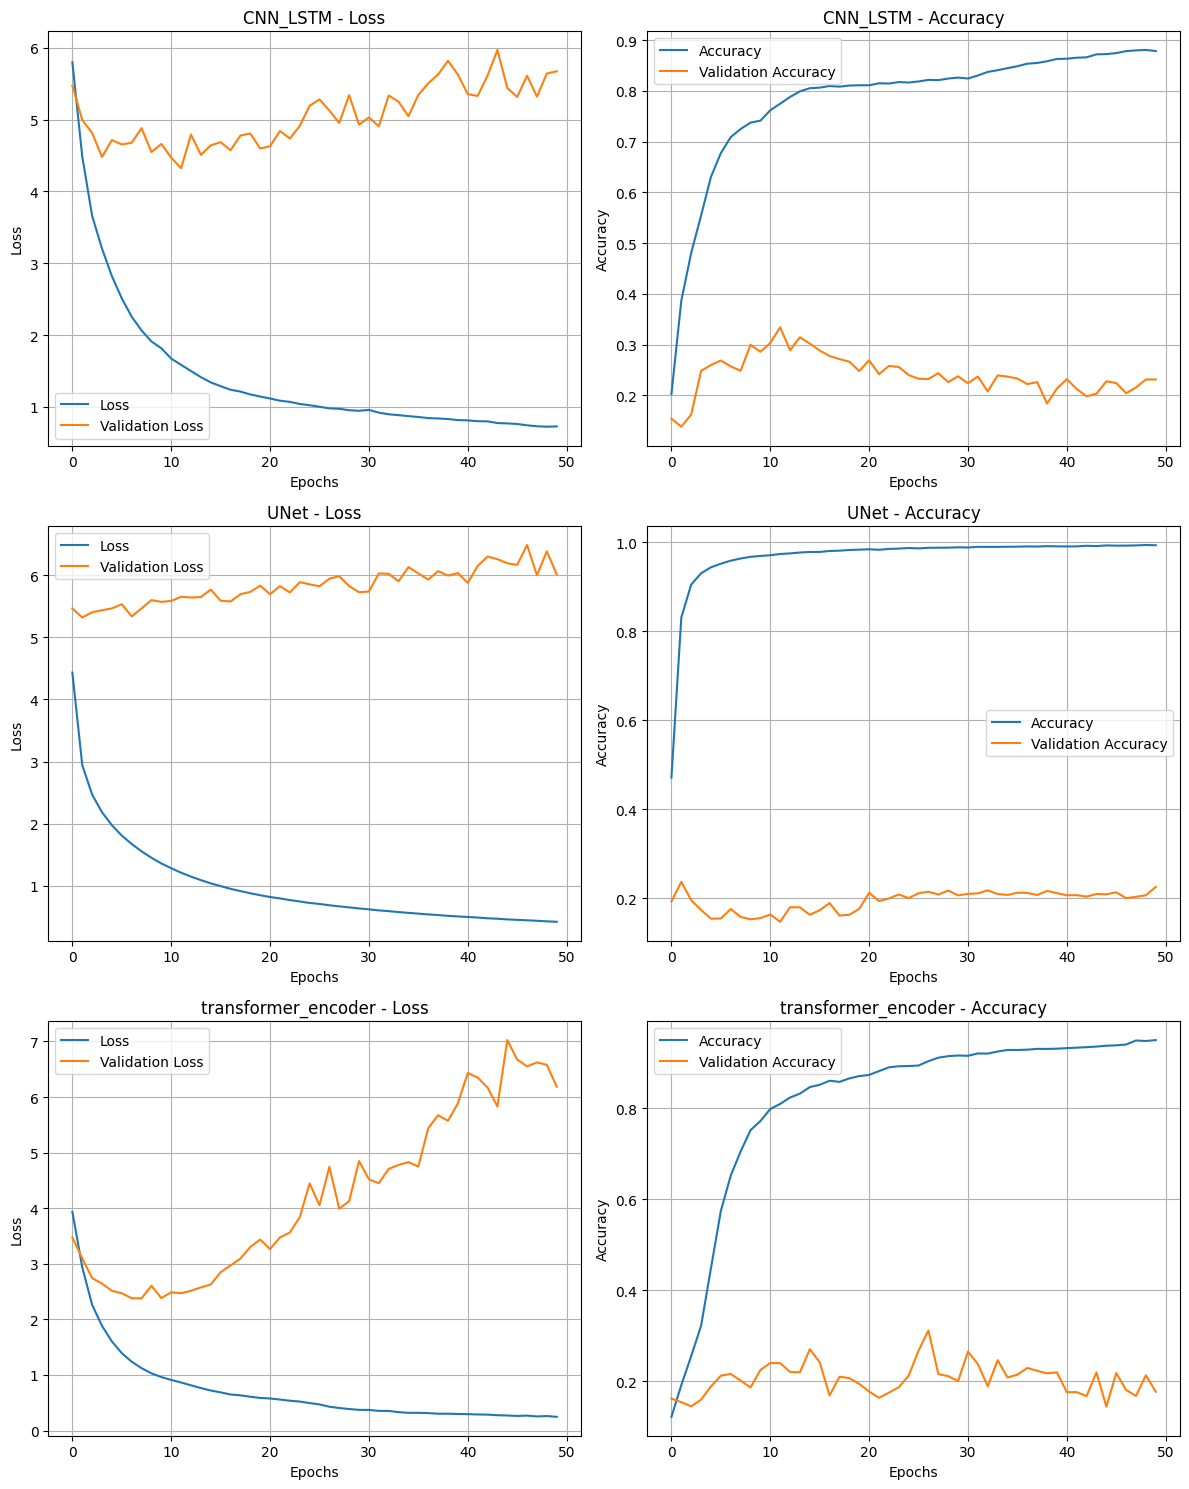

In [40]:
# draw loss, val_loss, acc, val_acc

draw_history(histories_SMOTE)

In [41]:
# evaluate

evaluation_SMOTE = extract_train_test_scores(trained_models, X, y,
                                                 X_test_seq, y_test_seq)
print (evaluation_SMOTE)

{'CNN_LSTM': {'train_score': [1.6387226581573486, 0.7661724090576172], 'test_score': [2.495023250579834, 0.5767092108726501]}, 'UNet': {'train_score': [1.5373902320861816, 0.8373609185218811], 'test_score': [3.188857078552246, 0.45279034972190857]}, 'transformer_encoder': {'train_score': [2.0811166763305664, 0.7140547633171082], 'test_score': [3.9066884517669678, 0.5055086612701416]}}


In [42]:
# get accuracy, precision, recall, F1 score

performances_SMOTE = extract_performance_metrics(trained_models, X_test_seq, y_test_seq)
print (performances_SMOTE)

2024-11-04 07:53:13.712325: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-04 07:53:13.713709: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-04 07:53:13.714640: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

607/607 [==============================] - 2s 2ms/step
{'CNN_LSTM': {'accuracy': 0.5767092257001647, 'precision': 0.4623557419302552, 'recall': 0.5767092257001647, 'f1_score': 0.5025696994759183}, 'UNet': {'accuracy': 0.45279036243822074, 'precision': 0.4363588861016978, 'recall': 0.45279036243822074, 'f1_score': 0.42199071823221346}, 'transformer_encoder': {'accuracy': 0.5055086490939045, 'precision': 0.5087525268877314, 'recall': 0.5055086490939045, 'f1_score': 0.4801969063360456}}


607/607 [==============================] - 2s 4ms/step
Classification Report for CNN_LSTM:

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1208
           1       0.67      0.99      0.80      1147
           2       0.58      0.84      0.69      1258
           3       0.44      0.79      0.56      3263
           4       0.54      0.80      0.64      1012
           5       0.92      0.94      0.93      2408
           6       0.00      0.00      0.00      2880
           7       0.49      0.31      0.38      1466
           8       0.26      0.28      0.27      1063
           9       0.49      0.78      0.60      1313
          10       0.00      0.00      0.00      1649
          11       0.64      0.58      0.61       757

    accuracy                           0.58     19424
   macro avg       0.50      0.60      0.54     19424
weighted avg       0.46      0.58      0.50     19424



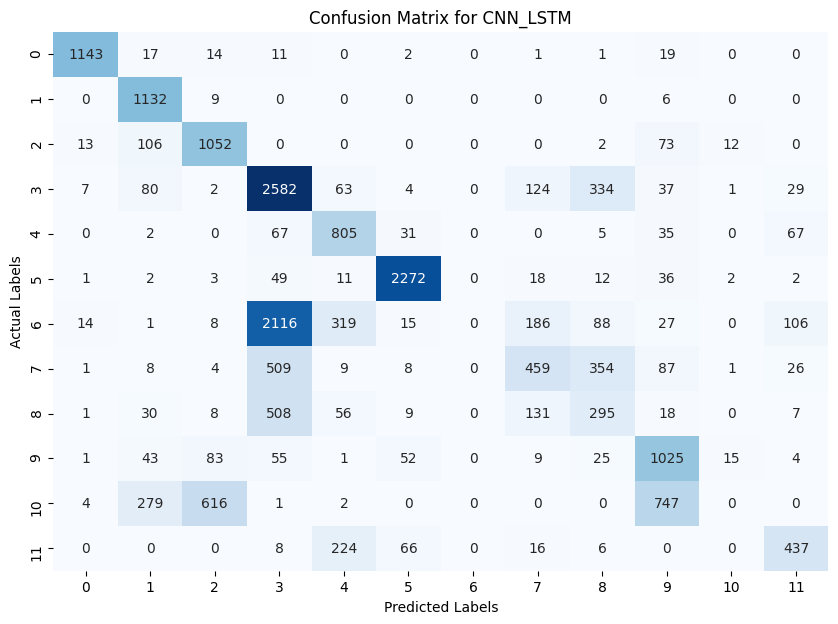

607/607 [==============================] - 1s 2ms/step
Classification Report for UNet:

              precision    recall  f1-score   support

           0       0.01      0.00      0.00      1208
           1       0.07      0.02      0.03      1147
           2       0.31      0.55      0.40      1258
           3       0.59      0.65      0.62      3263
           4       0.16      0.09      0.11      1012
           5       0.95      0.89      0.92      2408
           6       0.68      0.34      0.45      2880
           7       0.31      0.51      0.39      1466
           8       0.25      0.56      0.35      1063
           9       0.40      0.67      0.50      1313
          10       0.07      0.02      0.03      1649
          11       0.36      0.65      0.46       757

    accuracy                           0.45     19424
   macro avg       0.35      0.41      0.36     19424
weighted avg       0.44      0.45      0.42     19424



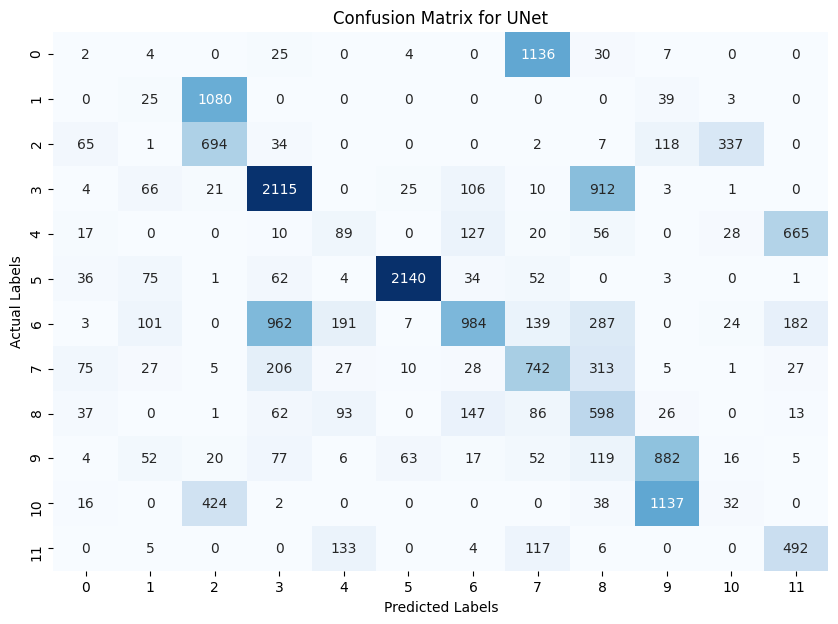

607/607 [==============================] - 1s 2ms/step
Classification Report for transformer_encoder:

              precision    recall  f1-score   support

           0       0.50      0.95      0.66      1208
           1       0.42      0.96      0.59      1147
           2       0.35      0.48      0.40      1258
           3       0.63      0.60      0.61      3263
           4       0.56      0.53      0.54      1012
           5       0.89      0.67      0.76      2408
           6       0.70      0.35      0.46      2880
           7       0.37      0.43      0.40      1466
           8       0.32      0.69      0.44      1063
           9       0.14      0.10      0.11      1313
          10       0.02      0.00      0.00      1649
          11       0.62      0.50      0.55       757

    accuracy                           0.51     19424
   macro avg       0.46      0.52      0.46     19424
weighted avg       0.51      0.51      0.48     19424



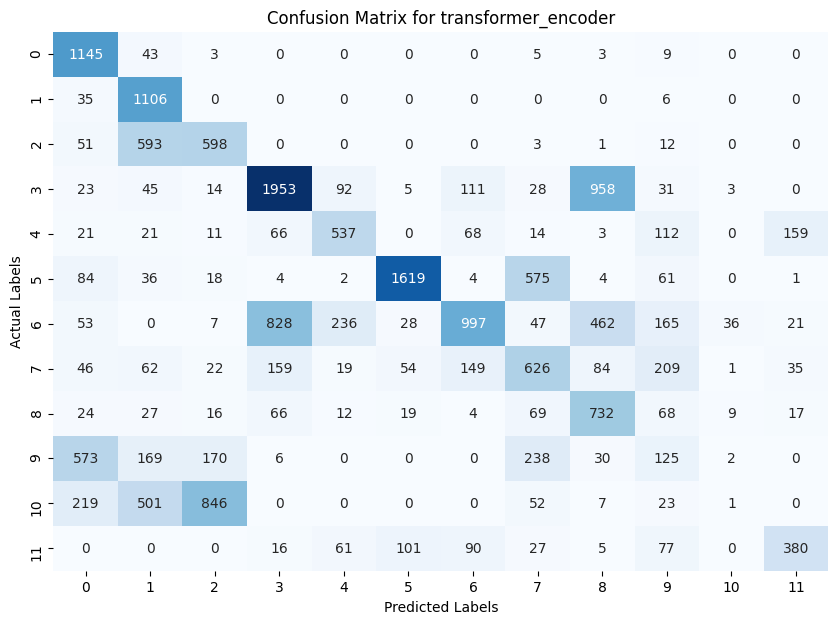

In [43]:
# draw confusion matrix, print the report

plot_classification_report_confusion_matrix(trained_models, X_test_seq, y_test_seq)

------

### T-SMOTE

- **Reference**
    - https://www.ijcai.org/proceedings/2022/0334.pdf
   
   
    abstract
    
    Time series classifcation is a popular and important topic in machine learning, and it suffers from the class imbalance problem in many real-world applications. In this paper, to address the class imbalance problem, we propose a novel and practical oversampling method named T-SMOTE, which can make full use of the temporal information of time-series data. In particular, for each sample of minority class, T-SMOTE generates multiple samples that are close to class border. Then, based on those samples near class border, T-SMOTE synthesizes more samples. Finally, a weighted sampling method is called on both generated samples near class border and synthetic samples. Extensive experiments on a diverse set of both univariate and multivariate time-series datasets demonstrate that T-SMOTE consistently outperforms the current state-of-the-art methods on imbalanced time series classifcation. More encouragingly, our empirical evaluations show that T-SMOTE performs better in the scenario of early prediction, an important application scenario in industry, which indicates that T-SMOTE could bring benefts in practice. 
    
    
As mentioned in the paper, SMOTE may be suitable for general datasets where temporal dependencies do not exist; however, it is not appropriate to directly apply SMOTE to time-series data like PAMAP2. **Therefore, I will apply T-SMOTE**, which defines the time series based on non-overlapping bins ("slices") of equal size, generates synthetic data within each bin, builds a Markov model using the existing observations and synthetic elements of the samples, and feeds the model with the most probable paths. The code has been significantly modified from the unofficial version implemented by Hadlock-Lab at https://github.com/Hadlock-Lab/tSMOTE.

In [44]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from concurrent.futures import ThreadPoolExecutor

class OptimizedTSMOTE:
    def __init__(self, k_neighbors=5, random_state=None, n_jobs=-1):
        self.k_neighbors = k_neighbors
        self.random_state = random_state
        self.n_jobs = n_jobs  # Number of workers for parallel processing
        if random_state is not None:
            np.random.seed(random_state)

    def _find_temporal_neighbors(self, X, time_window):
        n_samples = X.shape[0]
        
        # Reshape data for vectorized distance calculation
        X_reshaped = X.reshape(n_samples, -1)
        
        # Parallelize KNN calculation
        nbrs = NearestNeighbors(
            n_neighbors=self.k_neighbors + 1,
            algorithm='ball_tree',  # Use faster algorithm
            n_jobs=self.n_jobs
        ).fit(X_reshaped)
        
        # Calculate distances and indices at once
        distances, indices = nbrs.kneighbors(X_reshaped)
        
        # Find neighbors using vectorized operations
        mask = distances <= time_window
        neighbors = [indices[i, 1:][mask[i, 1:]].tolist() for i in range(n_samples)]
        
        return neighbors

    def _generate_synthetic_samples_batch(self, samples, neighbors_list, n_synthetic):
        synthetic_samples = []
        valid_indices = [i for i, neighbors in enumerate(neighbors_list) if neighbors]
        
        if not valid_indices:
            return np.array([])
        
        # Generate samples in batch
        selected_indices = np.random.choice(valid_indices, n_synthetic)
        alphas = np.random.random(n_synthetic)
        
        for idx, alpha in zip(selected_indices, alphas):
            sample = samples[idx]
            neighbor = samples[np.random.choice(neighbors_list[idx])]
            synthetic_sample = sample + alpha * (neighbor - sample)
            synthetic_samples.append(synthetic_sample)
            
        return np.array(synthetic_samples)

    def fit_resample(self, X, y, time_window=1.0):
        X = np.asarray(X)
        y = np.asarray(y)
        
        # Calculate class distribution
        unique_classes, class_counts = np.unique(y, return_counts=True)
        majority_class = unique_classes[np.argmax(class_counts)]
        n_majority = np.max(class_counts)
        
        X_resampled = []
        y_resampled = []
        
        # Process only minority classes
        minority_classes = unique_classes[unique_classes != majority_class]
        
        for class_label in minority_classes:
            class_indices = np.where(y == class_label)[0]
            class_samples = X[class_indices]
            
            # Find neighbors (once per class)
            temporal_neighbors = self._find_temporal_neighbors(class_samples, time_window)
            n_synthetic = n_majority - len(class_indices)
            
            # Generate synthetic samples in batch
            synthetic_samples = self._generate_synthetic_samples_batch(
                class_samples, temporal_neighbors, n_synthetic
            )
            
            if len(synthetic_samples) > 0:
                X_resampled.append(synthetic_samples)
                y_resampled.append(np.full(len(synthetic_samples), class_label))
        
        # Combine final results
        if X_resampled:
            return np.vstack(X_resampled), np.hstack(y_resampled)
        return np.array([]), np.array([])

In [45]:
tsmote = OptimizedTSMOTE()

X_resampled, y_resampled = tsmote.fit_resample(X_train_seq, y_train_seq, time_window=100)

print("Resampled X shape:", X_resampled.shape)
print("Resampled y shape:", y_resampled.shape)
print("Resampled y distribution:", np.unique(y_resampled, return_counts=True))

Resampled X shape: (45722, 100, 35)
Resampled y shape: (45722,)
Resampled y distribution: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11]), array([1869, 2173, 2049, 1608, 6387, 4465, 3762, 5892, 6104, 2835, 8578]))


In [46]:
# Concatenate the original training data (X_train_seq, y_train_seq) with the augmented data
X = np.vstack((X_train_seq, X_resampled))  # Stack sequences vertically
y = np.concatenate((y_train_seq, y_resampled))  # Concatenate labels

# Print the shapes of the final feature and target arrays
print(X.shape, y.shape)


(123432, 100, 35) (123432,)


In [47]:
# fit

histories_T_SMOTE, trained_models = activate_all_model(X, y, input_shape, n_classes)

2024-11-04 07:57:39.804414: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-04 07:57:39.805585: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-04 07:57:39.806671: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

CNN_LSTM model parameters: 107228
UNet model parameters: 164572
Transformer Encoder model parameters: 114934
ERROR: Could not find file /tmp/ipykernel_36490/2750405356.py
model 0 running


2024-11-04 07:57:45.571301: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-04 07:57:45.577297: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-04 07:57:45.582911: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

epoch 1 completed : 23.82 seconds
epoch 2 completed : 3.29 seconds
epoch 3 completed : 3.23 seconds
epoch 4 completed : 3.24 seconds
epoch 5 completed : 3.27 seconds
epoch 6 completed : 3.35 seconds
epoch 7 completed : 3.16 seconds
epoch 8 completed : 3.26 seconds
epoch 9 completed : 3.32 seconds
epoch 10 completed : 3.25 seconds
epoch 11 completed : 3.30 seconds
epoch 12 completed : 3.24 seconds
epoch 13 completed : 3.33 seconds
epoch 14 completed : 3.33 seconds
epoch 15 completed : 3.29 seconds
epoch 16 completed : 3.25 seconds
epoch 17 completed : 3.30 seconds
epoch 18 completed : 3.27 seconds
epoch 19 completed : 3.39 seconds
epoch 20 completed : 3.24 seconds
epoch 21 completed : 3.23 seconds
epoch 22 completed : 3.29 seconds
epoch 23 completed : 3.31 seconds
epoch 24 completed : 3.30 seconds
epoch 25 completed : 3.35 seconds
epoch 26 completed : 3.27 seconds
epoch 27 completed : 3.29 seconds
epoch 28 completed : 3.25 seconds
epoch 29 completed : 3.30 seconds
epoch 30 completed : 3

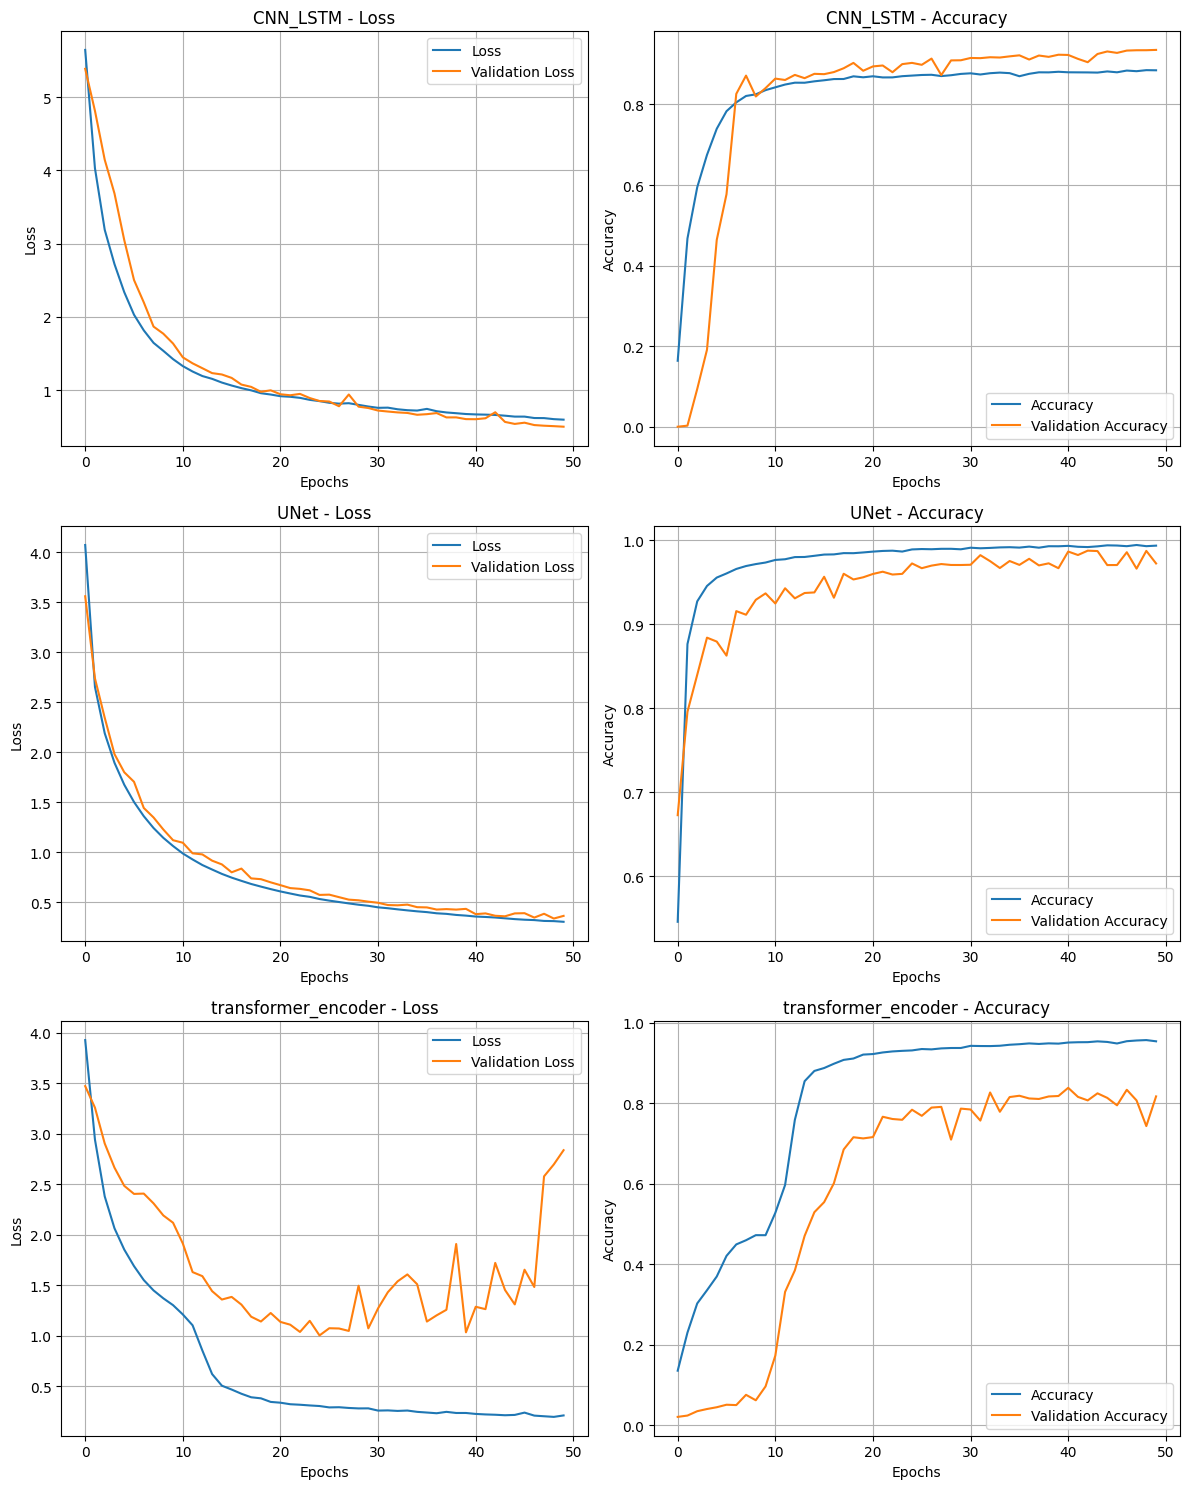

In [48]:
# draw loss, val_loss, acc, val_acc

draw_history(histories_T_SMOTE)

In [49]:
# evaluate

evaluation_T_SMOTE = extract_train_test_scores(trained_models, X, y,
                                                 X_test_seq, y_test_seq)
print (evaluation_T_SMOTE)

{'CNN_LSTM': {'train_score': [0.5177966952323914, 0.9088810086250305], 'test_score': [3.1700334548950195, 0.4157228171825409]}, 'UNet': {'train_score': [0.3132014870643616, 0.9890952110290527], 'test_score': [2.801759958267212, 0.5676997303962708]}, 'transformer_encoder': {'train_score': [0.9722245335578918, 0.8852242827415466], 'test_score': [4.369630336761475, 0.43590402603149414]}}


In [50]:
# get accuracy, precision, recall, F1 score

performances_T_SMOTE = extract_performance_metrics(trained_models, X_test_seq, y_test_seq)
print (performances_T_SMOTE)

2024-11-04 08:09:18.287120: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-04 08:09:18.288331: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-04 08:09:18.289527: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

607/607 [==============================] - 2s 2ms/step
{'CNN_LSTM': {'accuracy': 0.41572281713344317, 'precision': 0.37942104848750496, 'recall': 0.41572281713344317, 'f1_score': 0.3622060847368105}, 'UNet': {'accuracy': 0.5676997528830313, 'precision': 0.6738431801344071, 'recall': 0.5676997528830313, 'f1_score': 0.5399172793886676}, 'transformer_encoder': {'accuracy': 0.43590403624382207, 'precision': 0.4696331773068124, 'recall': 0.43590403624382207, 'f1_score': 0.4315537358442779}}


607/607 [==============================] - 2s 4ms/step
Classification Report for CNN_LSTM:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1208
           1       0.18      0.01      0.01      1147
           2       0.25      0.36      0.29      1258
           3       0.50      0.66      0.57      3263
           4       0.35      0.53      0.42      1012
           5       0.97      0.66      0.79      2408
           6       0.00      0.00      0.00      2880
           7       0.39      0.58      0.47      1466
           8       0.26      0.36      0.30      1063
           9       0.31      0.84      0.46      1313
          10       0.65      0.24      0.35      1649
          11       0.27      0.80      0.40       757

    accuracy                           0.42     19424
   macro avg       0.34      0.42      0.34     19424
weighted avg       0.38      0.42      0.36     19424



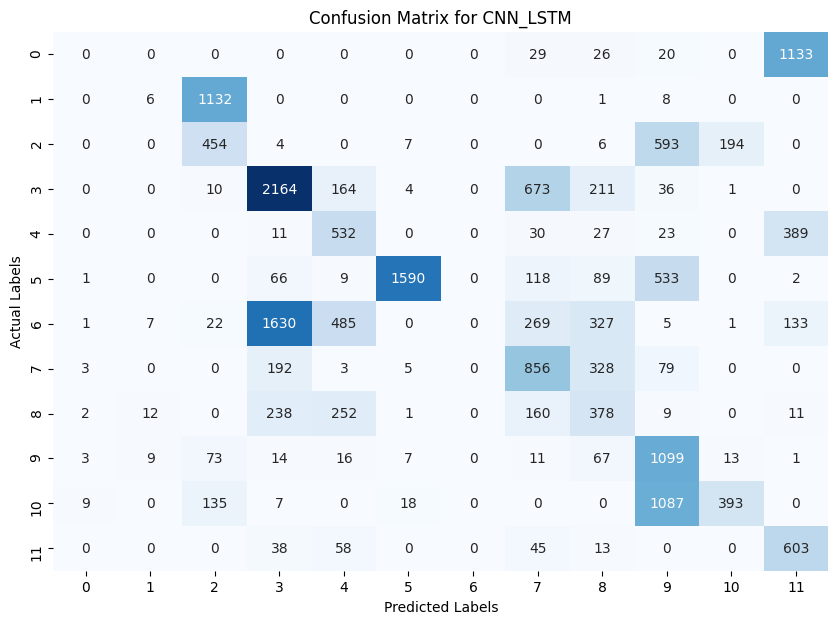

607/607 [==============================] - 1s 2ms/step
Classification Report for UNet:

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1208
           1       0.96      0.96      0.96      1147
           2       0.88      0.15      0.25      1258
           3       0.49      0.88      0.63      3263
           4       0.43      0.78      0.56      1012
           5       0.98      0.55      0.70      2408
           6       0.73      0.14      0.23      2880
           7       0.59      0.50      0.54      1466
           8       0.38      0.57      0.45      1063
           9       0.30      0.73      0.43      1313
          10       0.58      0.21      0.31      1649
          11       0.75      0.81      0.78       757

    accuracy                           0.57     19424
   macro avg       0.67      0.60      0.57     19424
weighted avg       0.67      0.57      0.54     19424



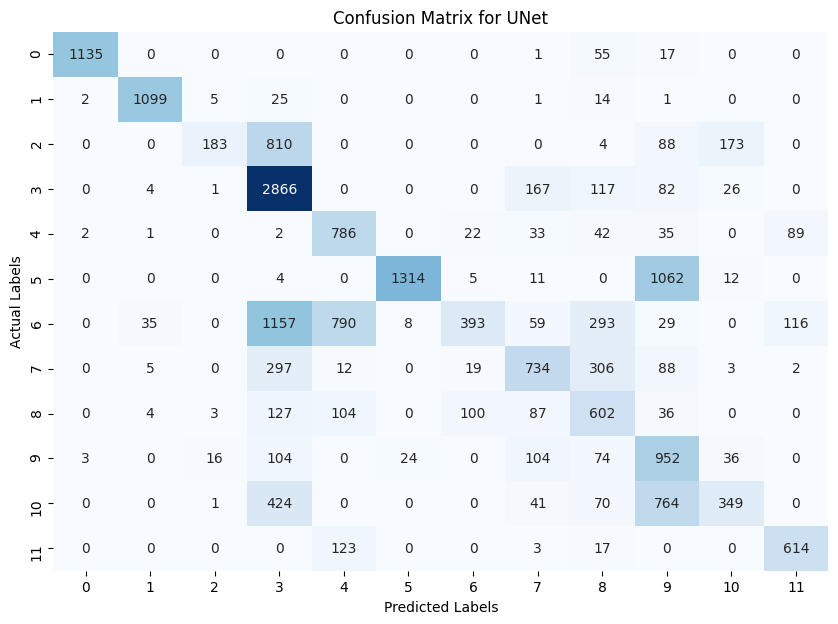

607/607 [==============================] - 1s 2ms/step
Classification Report for transformer_encoder:

              precision    recall  f1-score   support

           0       0.16      0.27      0.20      1208
           1       0.00      0.00      0.00      1147
           2       0.11      0.20      0.14      1258
           3       0.56      0.55      0.55      3263
           4       0.37      0.36      0.37      1012
           5       0.87      0.84      0.85      2408
           6       0.52      0.17      0.26      2880
           7       0.58      0.35      0.44      1466
           8       0.36      0.51      0.43      1063
           9       0.43      0.71      0.53      1313
          10       0.61      0.51      0.55      1649
          11       0.30      0.50      0.38       757

    accuracy                           0.44     19424
   macro avg       0.40      0.42      0.39     19424
weighted avg       0.47      0.44      0.43     19424



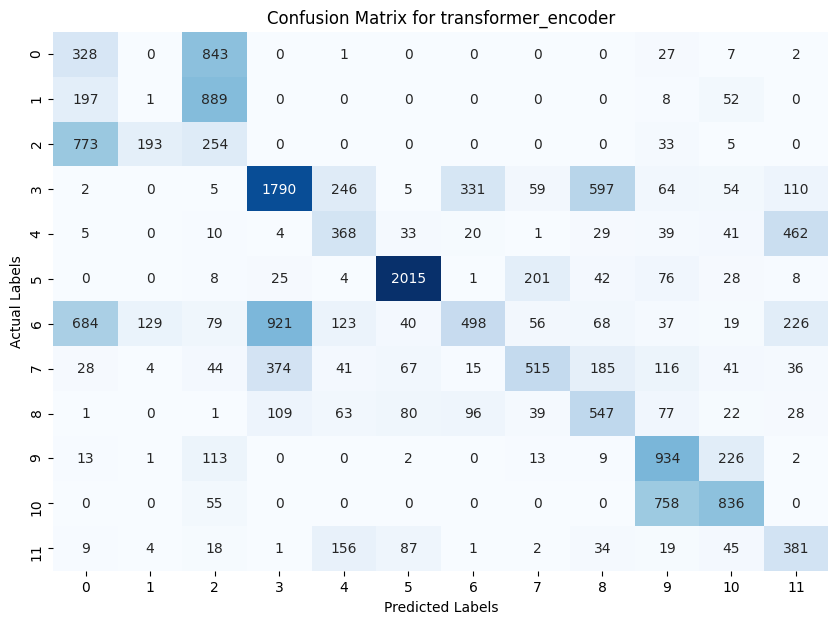

In [51]:
# draw confusion matrix, print the report

plot_classification_report_confusion_matrix(trained_models, X_test_seq, y_test_seq)

------


### comparison each augmentation result

In [53]:
evaluation_data = {
    "original": evaluation_original,
    "SMOTE" : evaluation_SMOTE,
    "T-SMOTE" : evaluation_T_SMOTE
}

performance_data = {
    "original": performances_original,
    "SMOTE" : performances_SMOTE,
    "T-SMOTE" : performances_T_SMOTE 
}

aug_list = ['original', 'SMOTE', 'T-SMOTE']
histories_dict = {
    "original": histories_original,
    "SMOTE" : histories_SMOTE,
    "T-SMOTE" : histories_T_SMOTE 
}


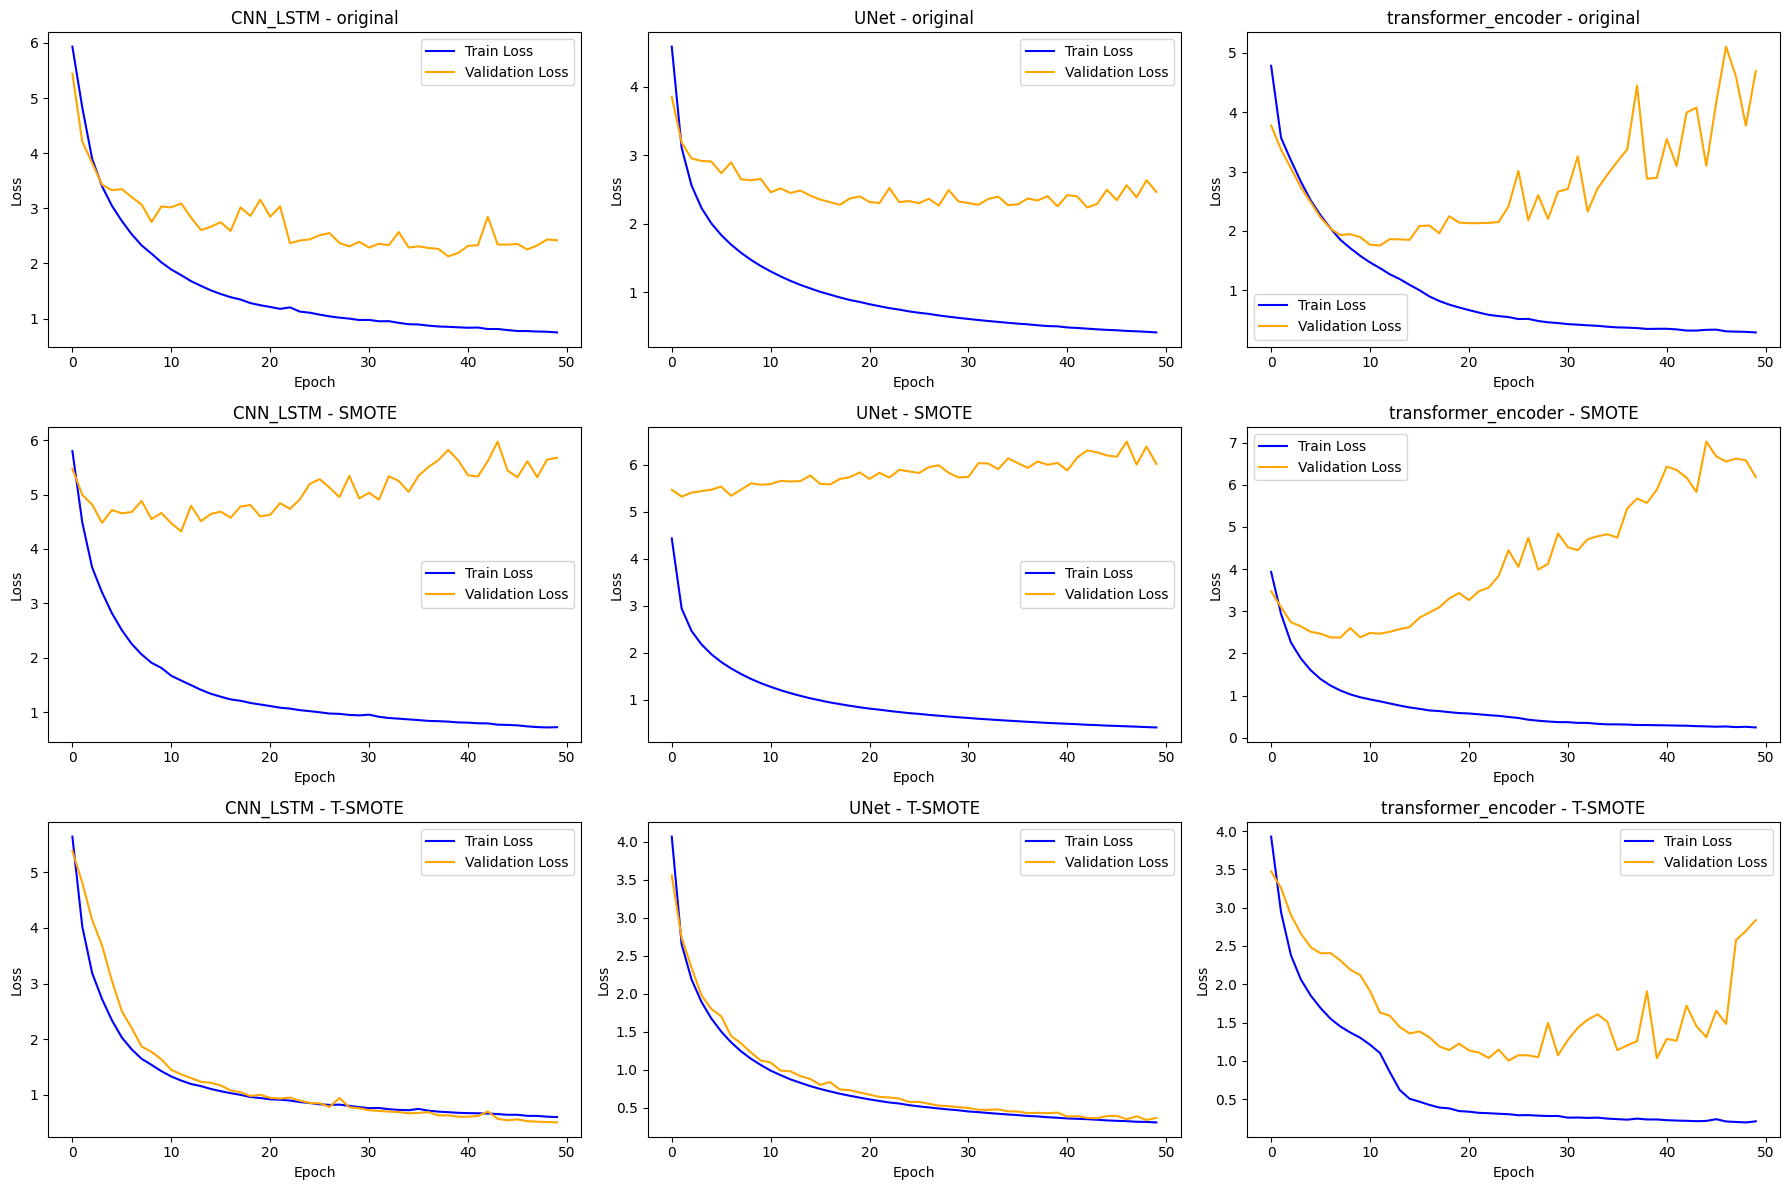

In [54]:
import matplotlib.pyplot as plt

def plot_augmented_losses(histories_dict, aug_list):
    fig, axes = plt.subplots(len(aug_list), 3, figsize=(18, len(aug_list) * 4))
    
    for i, aug in enumerate(aug_list):
        history = histories_dict[aug]
        
        for j, model_name in enumerate(['CNN_LSTM', 'UNet', 'transformer_encoder']):
            ax = axes[i, j] if len(aug_list) > 1 else axes[j]
            
            if history[model_name] is not None:
                ax.plot(history[model_name].history['loss'], label='Train Loss', color='b')
                ax.plot(history[model_name].history['val_loss'], label='Validation Loss', color='orange')
                
                ax.set_title(f"{model_name} - {aug}")
                ax.set_xlabel("Epoch")
                ax.set_ylabel("Loss")
                ax.legend()
            else:
                ax.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_augmented_losses(histories_dict, aug_list)


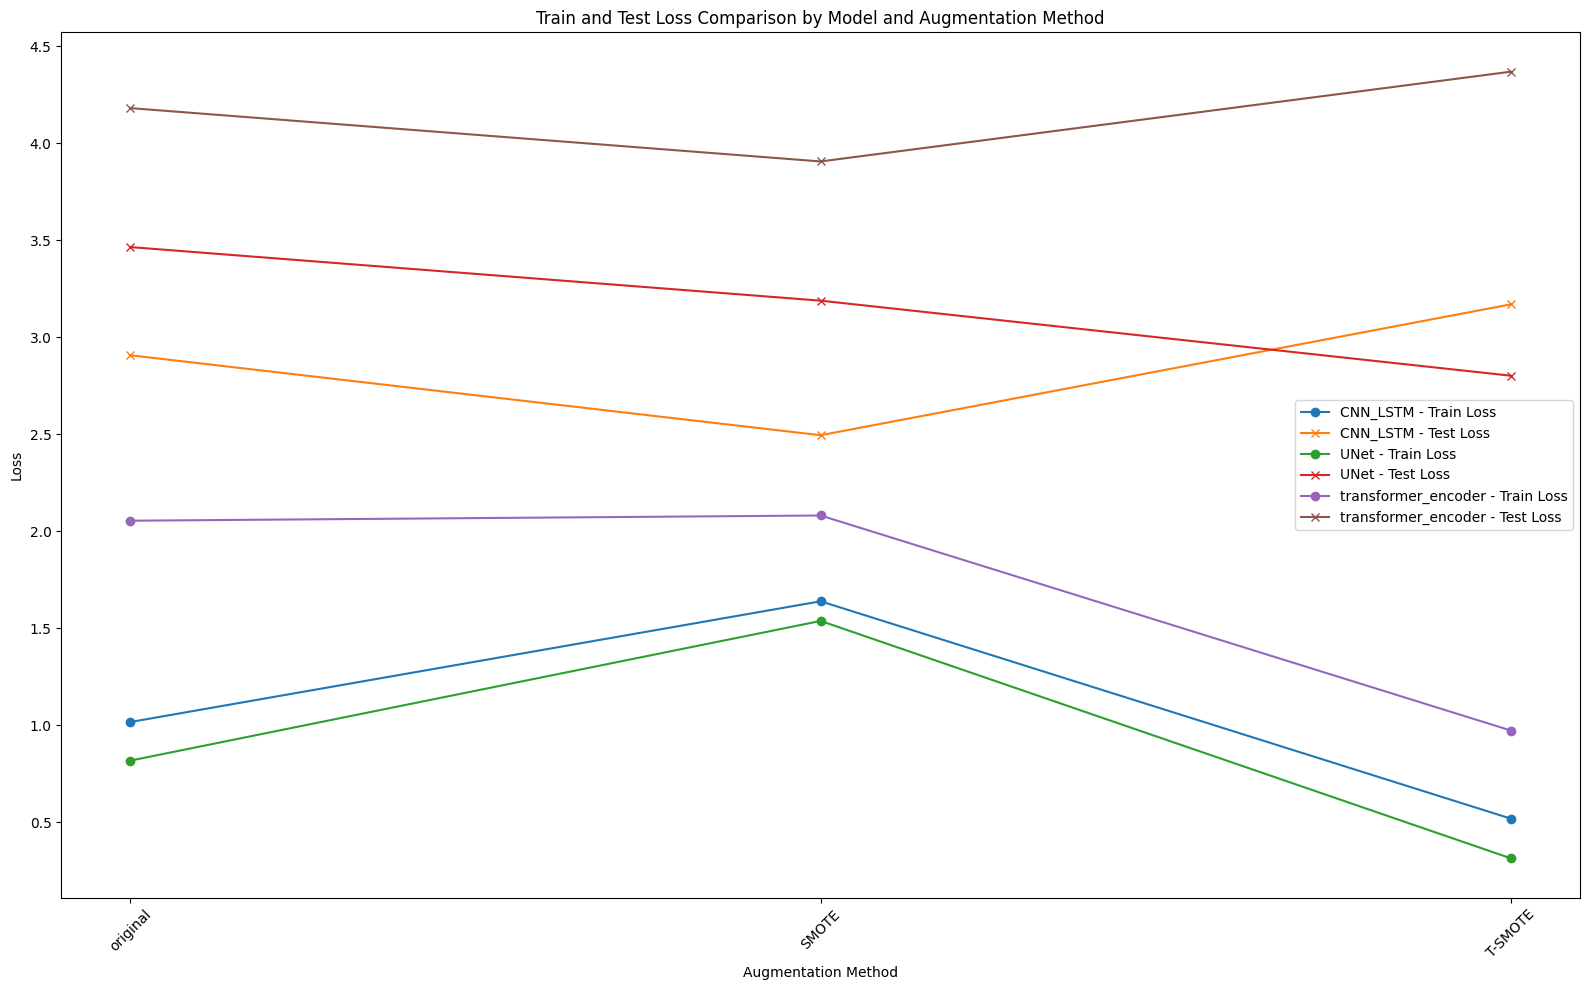

In [55]:
def plot_loss_comparison(evaluation_data):
    plt.figure(figsize=(16, 10))
    
    for model in ['CNN_LSTM', 'UNet', 'transformer_encoder']:
        train_losses = []
        test_losses = []
        aug_labels = []
        
        for aug, data in evaluation_data.items():
            train_loss = data[model]['train_score'][0]
            test_loss = data[model]['test_score'][0]
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            aug_labels.append(aug)
        
        plt.plot(aug_labels, train_losses, marker='o', label=f"{model} - Train Loss")
        plt.plot(aug_labels, test_losses, marker='x', label=f"{model} - Test Loss")

    plt.ylabel("Loss")
    plt.xlabel("Augmentation Method")
    plt.title("Train and Test Loss Comparison by Model and Augmentation Method")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_loss_comparison(evaluation_data)


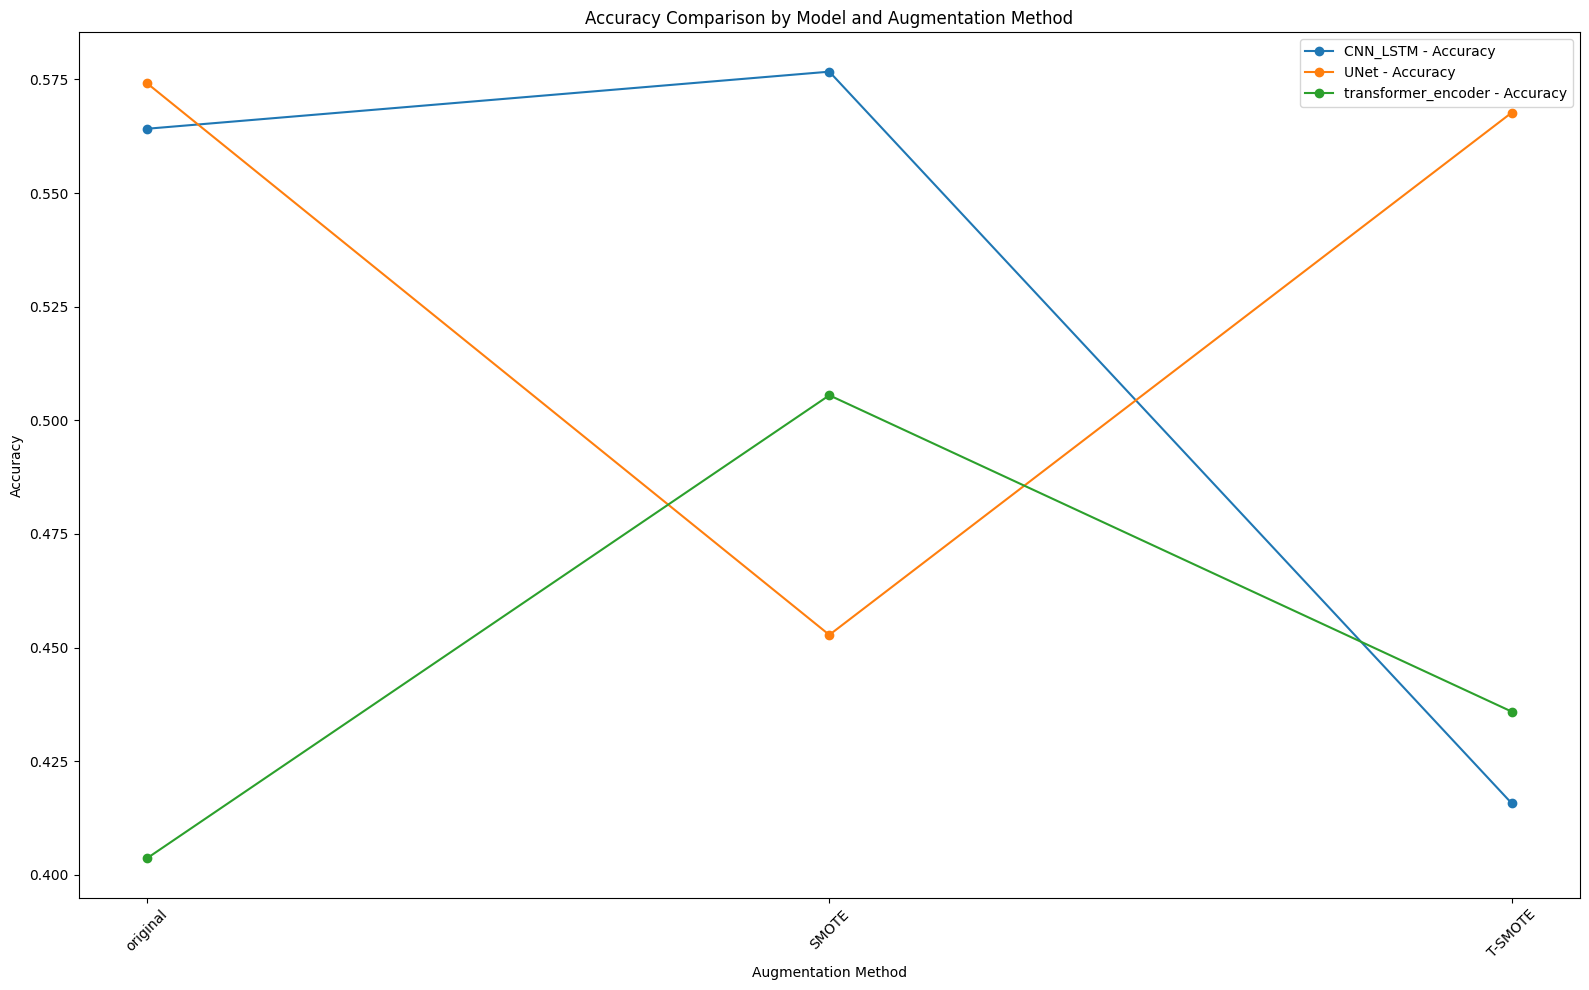

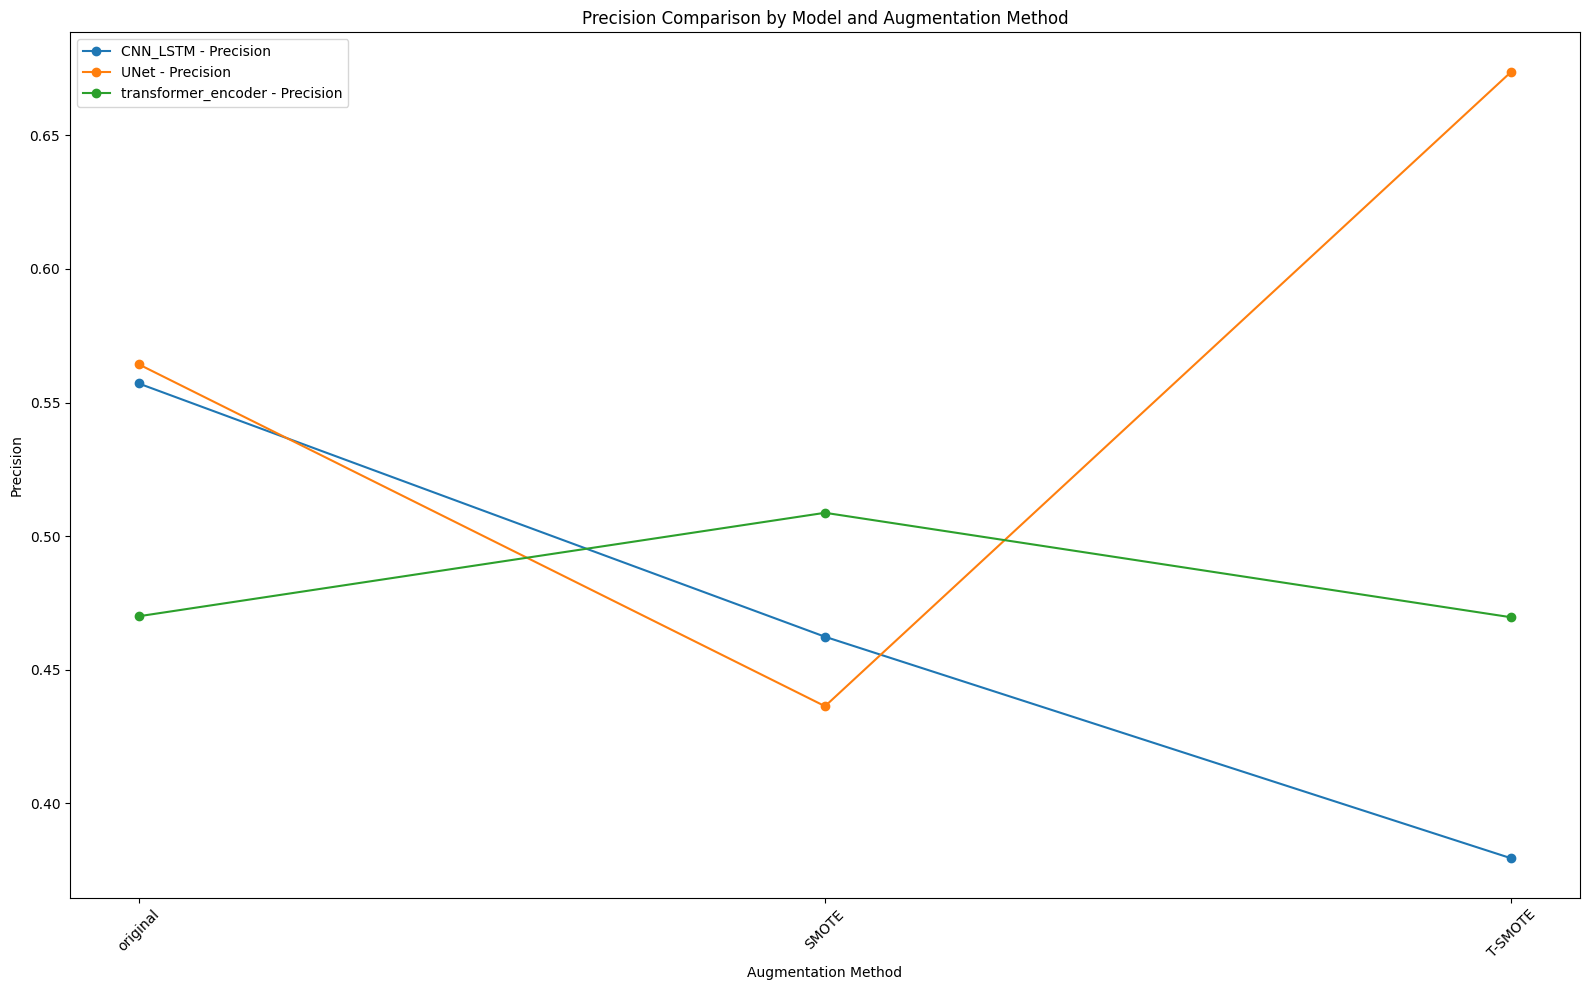

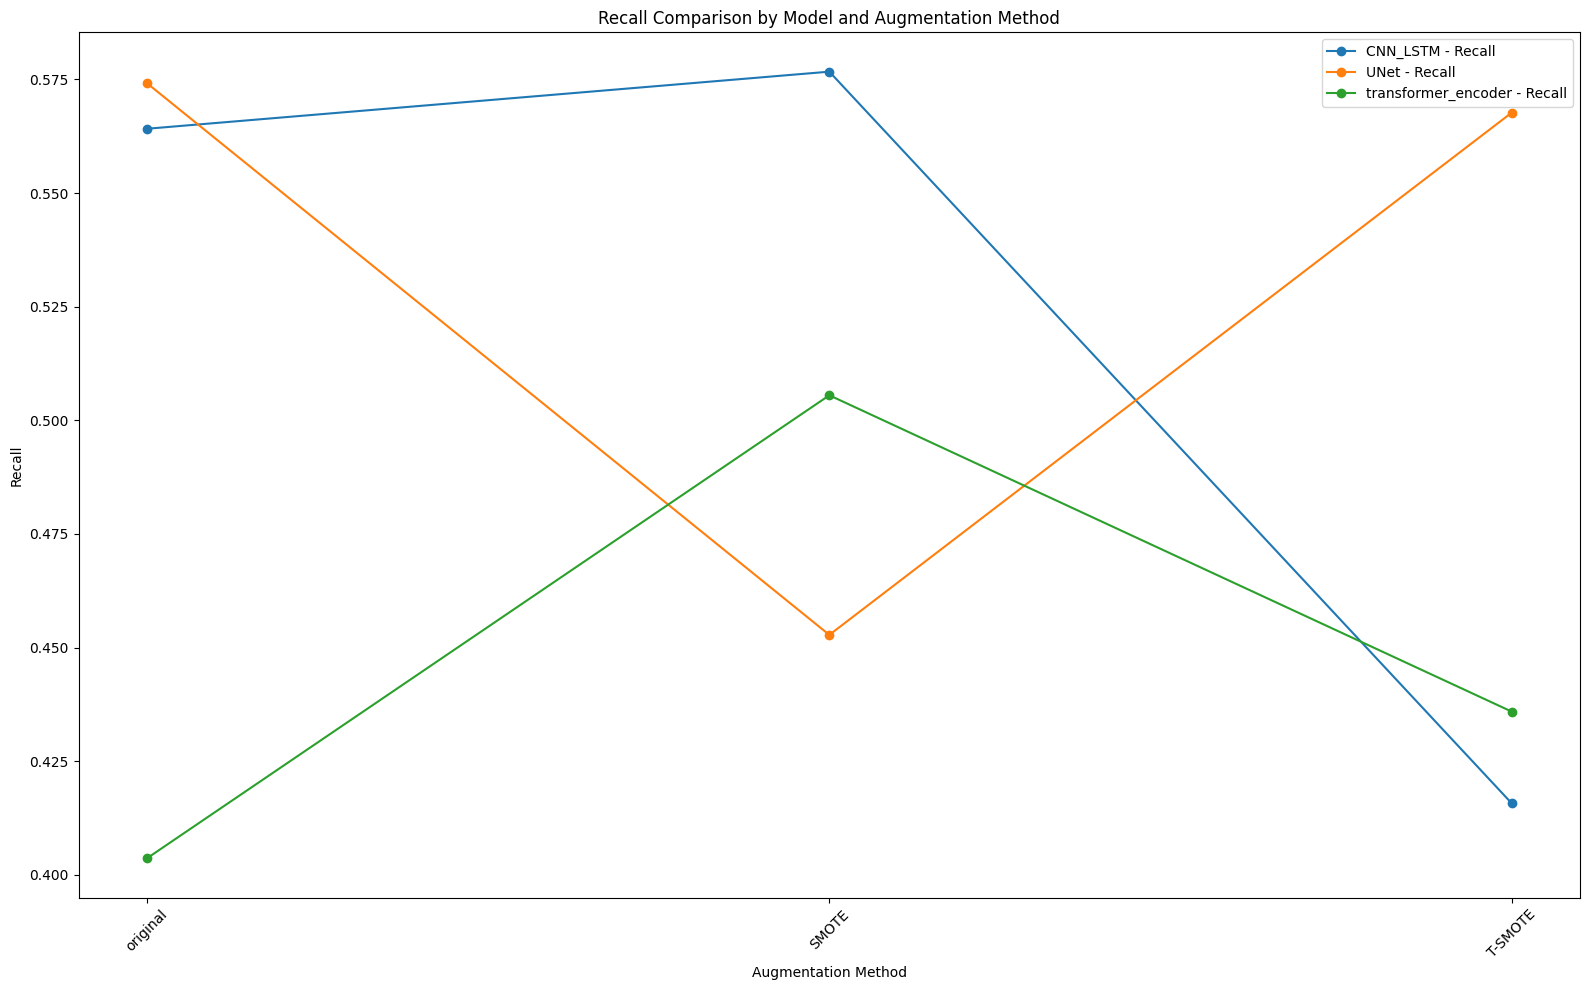

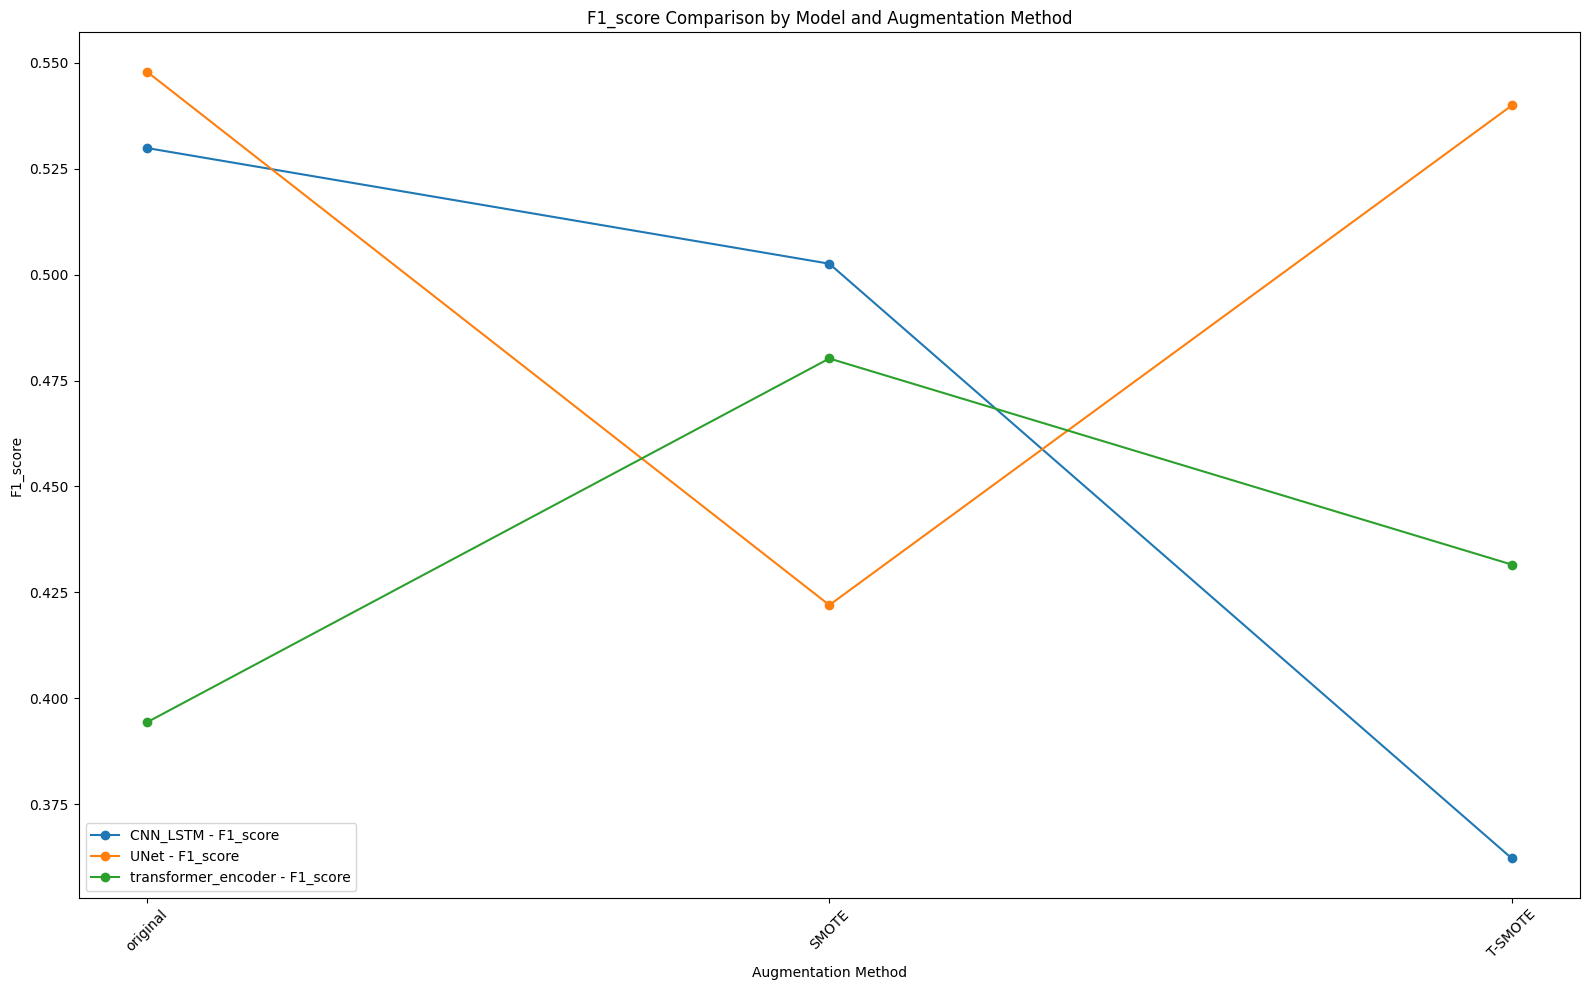

In [56]:
def plot_performance_comparison(performance_data, metric="accuracy"):
    plt.figure(figsize=(16, 10))
    
    for model in ['CNN_LSTM', 'UNet', 'transformer_encoder']:
        performance_scores = []
        aug_labels = []
        
        for aug, data in performance_data.items():
            performance = data[model][metric]
            performance_scores.append(performance)
            aug_labels.append(aug)
        
        plt.plot(aug_labels, performance_scores, marker='o', label=f"{model} - {metric.capitalize()}")

    plt.ylabel(metric.capitalize())
    plt.xlabel("Augmentation Method")
    plt.title(f"{metric.capitalize()} Comparison by Model and Augmentation Method")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_performance_comparison(performance_data, metric="accuracy")
plot_performance_comparison(performance_data, metric="precision")
plot_performance_comparison(performance_data, metric="recall")
plot_performance_comparison(performance_data, metric="f1_score")
